# ISIS-II Correction System for Closed Orbit Distortion
- Using manipulated simplified lattice
- Including storage and plotting of the RMS closed orbits

---
#### Load / import libraries

In [1]:
import os
import math
import subprocess
import numpy as np
import pandas as pnd

from cpymad.madx import Madx
import tfs

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#### Load / import helper functions

In [2]:
if os.name=='nt': # Windows
    %run ../../Scripts/helper_functions.py
    %run ../../../Scripts/cpymad_helpers.py
else: # Linux    
    %run '../../Scripts/helper_functions.py'
    %run '../../Scripts/cpymad_helpers.py'

# Functions 

In [3]:
from cpymad.types import Constraint
def match_tune(madx_instance, sequence, requested_q1, requested_q2, beta_limits, requested_dq1=None, requested_dq2=None):
    
    madx_instance.command.match(chrom=True)

    madx_instance.command.vary(name='qtdkvar', step=1E-4)
    madx_instance.command.vary(name='qtfkvar', step=1E-4)
    #madx_instance.command.vary(name='qf1kvar', step=1E-4)
    #madx_instance.command.vary(name='qf2kvar', step=1E-4)
    madx_instance.command.vary(name='qf4kvar', step=1E-4)
    #madx_instance.command.vary(name='qd1kvar', step=1E-4)
    #madx_instance.command.vary(name='qd2kvar', step=1E-4)
    #madx_instance.command.vary(name='qd3kvar', step=1E-4)
    madx_instance.command.vary(name='qd4kvar', step=1E-4)

    if requested_dq1 or requested_dq2 == None:
        madx_instance.command.global_(sequence=sequence, q1=requested_q1, q2=requested_q2)
    else:
        madx_instance.command.global_(sequence=sequence, q1=requested_q1, q2=requested_q2, dq1=requested_dq1, dq2=requested_dq2)

    constraints=[ dict(range='m1_0/m3_0', dx=Constraint(max=0.)),
        dict(range='minj1_0', betx=Constraint(min=0.,max=beta_limits[0]), bety=Constraint(min=0.,max=beta_limits[1])),
        dict(range='minj2_0', betx=Constraint(min=0.,max=beta_limits[0]), bety=Constraint(min=0.,max=beta_limits[1])),
        dict(range='m1_1/m3_1', dx=Constraint(max=0.)),
        dict(range='minj1_1', betx=Constraint(min=0.,max=beta_limits[0]), bety=Constraint(min=0.,max=beta_limits[1])),
        dict(range='minj2_1', betx=Constraint(min=0.,max=beta_limits[0]), bety=Constraint(min=0.,max=beta_limits[1])),
        dict(range='m1_2/m3_2', dx=Constraint(max=0.)),
        dict(range='minj1_2', betx=Constraint(min=0.,max=beta_limits[0]), bety=Constraint(min=0.,max=beta_limits[1])),
        dict(range='minj2_2', betx=Constraint(min=0.,max=beta_limits[0]), bety=Constraint(min=0.,max=beta_limits[1]))]

    for c in constraints:
            madx_instance.command.constraint(**c)
        
    madx_instance.command.jacobian(calls=50000, tolerance=1e-6)
    madx_instance.command.endmatch()


In [4]:
def cpymad_implement_cod_errors(madx_instance, cpymad_logfile, sequence_name, error_filename, use_errors='jparc'):

# use sequence (only once)
    madx_command = 'use, sequence='+ sequence_name +';'
    madx_instance.input(madx_command)

# Seed random number sequence
    madx_command = 'eoption, seed='+ str(int(np.random.uniform(0, 1E5)))  +', add=false;'
    madx_instance.input(madx_command)
    
    if use_errors == ('ess' or 'ESS'):
        madx_command = '''    
        disp_x  = 0.3;          // (mm)     Quadrupole misalignment in x direction
        disp_y  = 0.3;          // (mm)     Quadrupole misalignment in y direction
        ang     = 0.1;          // (mrad)   Dipole rotations
        dB_D    = 3e-4;         //          Relative field errors in the dipoles
        dB_Q    = 3e-4;         //          Relative field errors in the quadrupoles
        mond_x  = 0.8;          // (mm)     Monitor misalignment/processing error in x direction (0.3, 0.5)
        mond_y  = 0.8;          // (mm)     Monitor misalignment/processing error in y direction (0.3, 0.5)
        '''
    elif use_errors == ('jparc' or 'JPARC'):
        madx_command = '''    
        disp_x  = 0.25;         // (mm)     Quadrupole misalignment in x direction
        disp_y  = 0.25;         // (mm)     Quadrupole misalignment in y direction
        ang     = 0.5;          // (mrad)   Dipole rotations
        dB_D    = 1e-4;         //          Relative field errors in the dipoles
        dB_Q    = 1e-4;         //          Relative field errors in the quadrupoles
        mond_x  = 0.45;         // (mm)     Monitor misalignment/processing error in x direction (0.25, 0.2)
        mond_y  = 0.45;         // (mm)     Monitor misalignment/processing error in y direction (0.25, 0.2)
        '''
    else:
        madx_command = '''    
        disp_x  = 0.25;         // (mm)     Quadrupole misalignment in x direction
        disp_y  = 0.25;         // (mm)     Quadrupole misalignment in y direction
        ang     = 0.5;          // (mrad)   Dipole rotations
        dB_D    = 1e-4;         //          Relative field errors in the dipoles
        dB_Q    = 1e-4;         //          Relative field errors in the quadrupoles
        mond_x  = 0.45;         // (mm)     Monitor misalignment/processing error in x direction (0.25, 0.2)
        mond_y  = 0.45;         // (mm)     Monitor misalignment/processing error in y direction (0.25, 0.2)
        '''
    madx_instance.input(madx_command)
    
# Apply quadrupole alignment errors
    madx_command = '''
    select, flag = error, clear;
    select, flag = error, class = quadrupole;
    ealign, dx := disp_x * 1e-3 * gauss(), dy := disp_y * 1e-3 * gauss();
    '''
    madx_instance.input(madx_command)

# Apply quadrupole field errors
    madx_command = '''
    select, flag = error, clear;
    select, flag = error, class = quadrupole;
    efcomp, order=1, radius=1, dknr := {0, db_Q * gauss()};
    '''
    madx_instance.input(madx_command)
    
# Apply dipole alignment errors
    madx_command = '''
    select, flag = error, clear;
    select, flag = error, class = sbend;
    ealign, dpsi := ang * 1e-3 * gauss();
    '''
    madx_instance.input(madx_command)
    
# Apply dipole field errors
    madx_command = '''
    select, flag = error, clear;
    select, flag = error, class = sbend;
    efcomp, order=0, dkn := {dk0 * gauss()};
    '''
    madx_instance.input(madx_command)
    
# Apply monitor alignment errors
    madx_command = '''
    select, flag = error, clear;
    select, flag = error, class = monitor;
    ealign, mrex := mond_x * 1e-3 * gauss(), mrey := mond_y * 1e-3 * gauss();
    '''
    madx_instance.input(madx_command)  
    
    madx_command = '''
    select, flag = error, clear;
    select, flag = error, class = hmonitor;
    ealign, mrex := mond_x * 1e-3 * gauss(), mrey := mond_y * 1e-3 * gauss();
    '''
    madx_instance.input(madx_command)  
    
    madx_command = '''
    select, flag = error, clear;
    select, flag = error, class = vmonitor;
    ealign, mrex := mond_x * 1e-3 * gauss(), mrey := mond_y * 1e-3 * gauss();
    '''
    madx_instance.input(madx_command)  

    # Save errors to table
    madx_command = '''
    select, flag = error, clear;    
    select, flag = error, full;
    '''
    madx_instance.input(madx_command)  
    madx_command = 'esave, file=\"'+ error_filename +'\";'
    madx_instance.input(madx_command)
    
    # Set errors using file (?)
    madx_command = 'readtable, file=\"'+ error_filename +'\", table = err_tab;'
    madx_instance.input(madx_command)    
    madx_command = '''
    seterr, table = err_tab;
    '''
    #madx_instance.input(madx_command) 


In [5]:
def cpymad_plot_CO_RMS(madx_instance, df_myTwiss, df_uc_x, df_uc_y, df_c_x, df_c_m_x, df_c_y, df_c_m_y, sequence_name, save_file, ptc_twiss=False, beta_rel=None):
        
    if ptc_twiss:
        if beta_rel == None:
            print('cpymad_plot_CO: Error: ptc_twiss selected but no beta_rel supplied for dispersion normalisation')
            return False
    
    # Plot title = sequence_name + tunes
    qx = madx_instance.table.summ.q1[0]
    qy = madx_instance.table.summ.q2[0]     
    plot_title = sequence_name +' Q1='+format(qx,'2.3f')+', Q2='+ format(qy,'2.3f')
    
    # Start Plot
    heights = [1, 3, 2, 2]
    fig2 = plt.figure(figsize=(10,8),facecolor='w', edgecolor='k',constrained_layout=True);
    spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig2, height_ratios=heights);
    
    # Block diagram
    f2_ax1 = fig2.add_subplot(spec2[0]);
    f2_ax1.set_title(plot_title);  
    
    if ptc_twiss:
        block_diagram(f2_ax1, df_myTwiss, ptc_twiss=True)
    else: 
        block_diagram(f2_ax1, df_myTwiss, ptc_twiss=False)
    
    # Plot betas   
    f2_ax2 = fig2.add_subplot(spec2[1], sharex=f2_ax1);  
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['betx'],'b', label='$\\beta_x$');
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['bety'],'r', label='$\\beta_y$');  
    
    f2_ax2.legend(loc=2);
    f2_ax2.set_ylabel(r'$\beta_{x,y}$[m]');
    f2_ax2.grid(which='both', ls=':', lw=0.5, color='k');
    #f2_ax2.set_xlabel('s [m]')
    #f2_ax2.set_xticklabels([])
    
    if np.min(df_myTwiss['bety']) < np.min(df_myTwiss['betx']): bet_min = round_down_n(np.min(df_myTwiss['bety']),5)
    else: bet_min = round_down_n(np.min(df_myTwiss['betx']),5)
    if np.max(df_myTwiss['bety']) > np.max(df_myTwiss['betx']): bet_max = round_up_n(np.max(df_myTwiss['bety']),10)
    else: bet_max = round_up_n(np.max(df_myTwiss['betx']),10)        
    f2_ax2.set_ylim(bet_min,bet_max);
    
    ax2 = f2_ax2.twinx();   # instantiate a second axes that shares the same x-axis
    if ptc_twiss:     
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp1']/beta_rel,'green', label='$D_x$');
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp3']/beta_rel,'purple', label='$D_y$');
        key_dx = 'disp1';        key_dy = 'disp3';  
    
    else:
        ax2.plot(df_myTwiss['s'], df_myTwiss['dx'],'green', label='$D_x$');
        ax2.plot(df_myTwiss['s'], df_myTwiss['dy'],'purple', label='$D_y$');
        key_dx = 'dx';        key_dy = 'dy';  
        
    ax2.legend(loc=1);
    ax2.set_ylabel(r'$D_{x,y}$ [m]', color='green');  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='green');
    ax2.grid(which='both', ls=':', lw=0.5, color='green');

    if np.min(df_myTwiss[key_dy]) < np.min(df_myTwiss[key_dx]): d_min = round_down_n(np.min(df_myTwiss[key_dy]),1)
    else: d_min = round_down_n(np.min(df_myTwiss[key_dx]),1)    
    if np.max(df_myTwiss[key_dy]) > np.max(df_myTwiss[key_dx]): d_max = round_up_n(np.max(df_myTwiss[key_dy]),10)
    else: d_max = round_up_n(np.max(df_myTwiss[key_dx]),10) 
    ax2.set_ylim(d_min,d_max);
   
    f2_ax3 = fig2.add_subplot(spec2[2], sharex=f2_ax1);
    f2_ax3.plot(df_uc_x['S'], df_uc_x['X_RMS']*1E3, 'r', lw=1.5, label='x uncorrected');
    f2_ax3.plot(df_c_x['S'], df_c_x['X_RMS']*1E3, 'k', lw=1.5, ls=':', label='x corrected');
    f2_ax3.plot(df_c_m_x['S'], df_c_m_x['X_RMS']*1E3, 'k', lw=1.5, label='x corrected with monitor errors');
    
    f2_ax3.set_ylabel(r'x$_{RMS}$ [mm]');
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k');
    
    f2_ax4 = fig2.add_subplot(spec2[3], sharex=f2_ax1);
    f2_ax4.plot(df_uc_y['S'], df_uc_y['Y_RMS']*1E3, 'r', lw=1.5, label='y uncorrected');
    f2_ax4.plot(df_c_y['S'], df_c_y['Y_RMS']*1E3, 'k', lw=1.5, ls=':', label='y corrected');
    f2_ax4.plot(df_c_m_y['S'], df_c_m_y['Y_RMS']*1E3, 'k', lw=1.5, label='y corrected with monitor errors');
    
    f2_ax4.set_ylabel(r'y$_{RMS}$ [mm]');
    f2_ax4.grid(which='both', ls=':', lw=0.5, color='k'); 
    
    f2_ax3.legend(loc=2);
    f2_ax4.legend(loc=2);
    
    f2_ax3.set_ylim(0,10);
    f2_ax4.set_ylim(0,10);
    
    f2_ax4.set_xlabel('s [m]');
    
    #f2_ax4 = fig2.add_subplot(spec2[4], sharex=f2_ax1)   
    if save_file != None: 
        plt.savefig(save_file);
        plt.close();       

---
## Beam Parameters 

In [6]:
injected_beam = MADX_Proton_Beam_Parameters(400*1E6)

In [7]:
injected_beam.print_beam()

M_proton =  938.0 MeV
Energy =  0.4 GeV
Total Energy =  1.34 GeV
Gamma =  1.43
Beta =  0.713
Momentum =  0.95426286 GeV/c


In [8]:
extracted_beam = MADX_Proton_Beam_Parameters(1200*1E6)

In [9]:
extracted_beam.print_beam()

M_proton =  938.0 MeV
Energy =  1.2 GeV
Total Energy =  2.14 GeV
Gamma =  2.28
Beta =  0.899
Momentum =  1.9214195 GeV/c


---
---
# Closed Orbit Distortion (COD)

In [10]:
save_folder = 'Plots/'
make_directory(save_folder)
#legend_label = 'Case'
main_label = 'Cpymad_Correction'
output_line = 0

Successfully created the directory Plots/


### Start COD madx instance

In [11]:
cpymad_logfile = './cpymad_logfile.log'
madx = cpymad_start(cpymad_logfile)

In [12]:
output_line = cpymad_print_output(cpymad_logfile)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.09.21 13:31:32      +
  ++++++++++++++++++++++++++++++++++++++++++++

! cpymad_start called


### Load Master Lattice

In [13]:
master_lattice_dir = 'Example_Lattice/'

madx.call(file=master_lattice_dir+'Example_Synchrotron.beam')
madx.call(file=master_lattice_dir+'Example_Synchrotron.strength')
madx.call(file=master_lattice_dir+'Example_Synchrotron.elements')
madx.call(file=master_lattice_dir+'Example_Synchrotron.sequence')  

In [14]:
output_line = cpymad_print_output(cpymad_logfile, output_line)

! main sbends

!-----------------------------

bangledeg = 30.0;

edge=0.0*3.14159/180.;

blen = 3.4;

bangle = bangledeg*3.14159/180.;

b_edge = 0.0;

bkval = 0.0;



! quadrupoles

!-----------------------------

qtfkvar=0.000000;

qtdkvar=-0.000000;



qf1kvar=5.107288e-01;

qf2kvar=5.107288e-01;

qf4kvar=6.021386e-01;

qd1kvar=-6.651596e-01;

qd2kvar=-5.889184e-01;

qd3kvar=-5.889184e-01;

qd4kvar=-4.625177e-01;



! sextupoles

!-----------------------------

s3yk2var  = 0.0;

s2yk2var  = 0.0;

s1yk2var  = 0.0;

s2xk2var  = 0.0;

s1xk2var  = 0.0;

! Main dipole

!-----------------------------

b1 : sbend, l:=blen, angle:=bangle, e1:=b_edge, e2:=b_edge, k1:=bkval;

b1_0 : sbend, l:=blen, angle:=bangle, e1:=b_edge, e2:=b_edge, k1:=bkval;

b1_1 : sbend, l:=blen, angle:=bangle, e1:=b_edge, e2:=b_edge, k1:=bkval;

b1_2 : sbend, l:=blen, angle:=bangle, e1:=b_edge, e2:=b_edge, k1:=bkval;

b1_3 : sbend, l:=blen, angle:=bangle, e1:=b_edge, e2:=b_edge, k1:=bkval;

b1_4 : sbend, l:=blen, ang

# Basic Twiss

Sequence sp_corr exists in this instance of MAD-X
Active sequence:

{'sp_corr': <Sequence: sp_corr>}


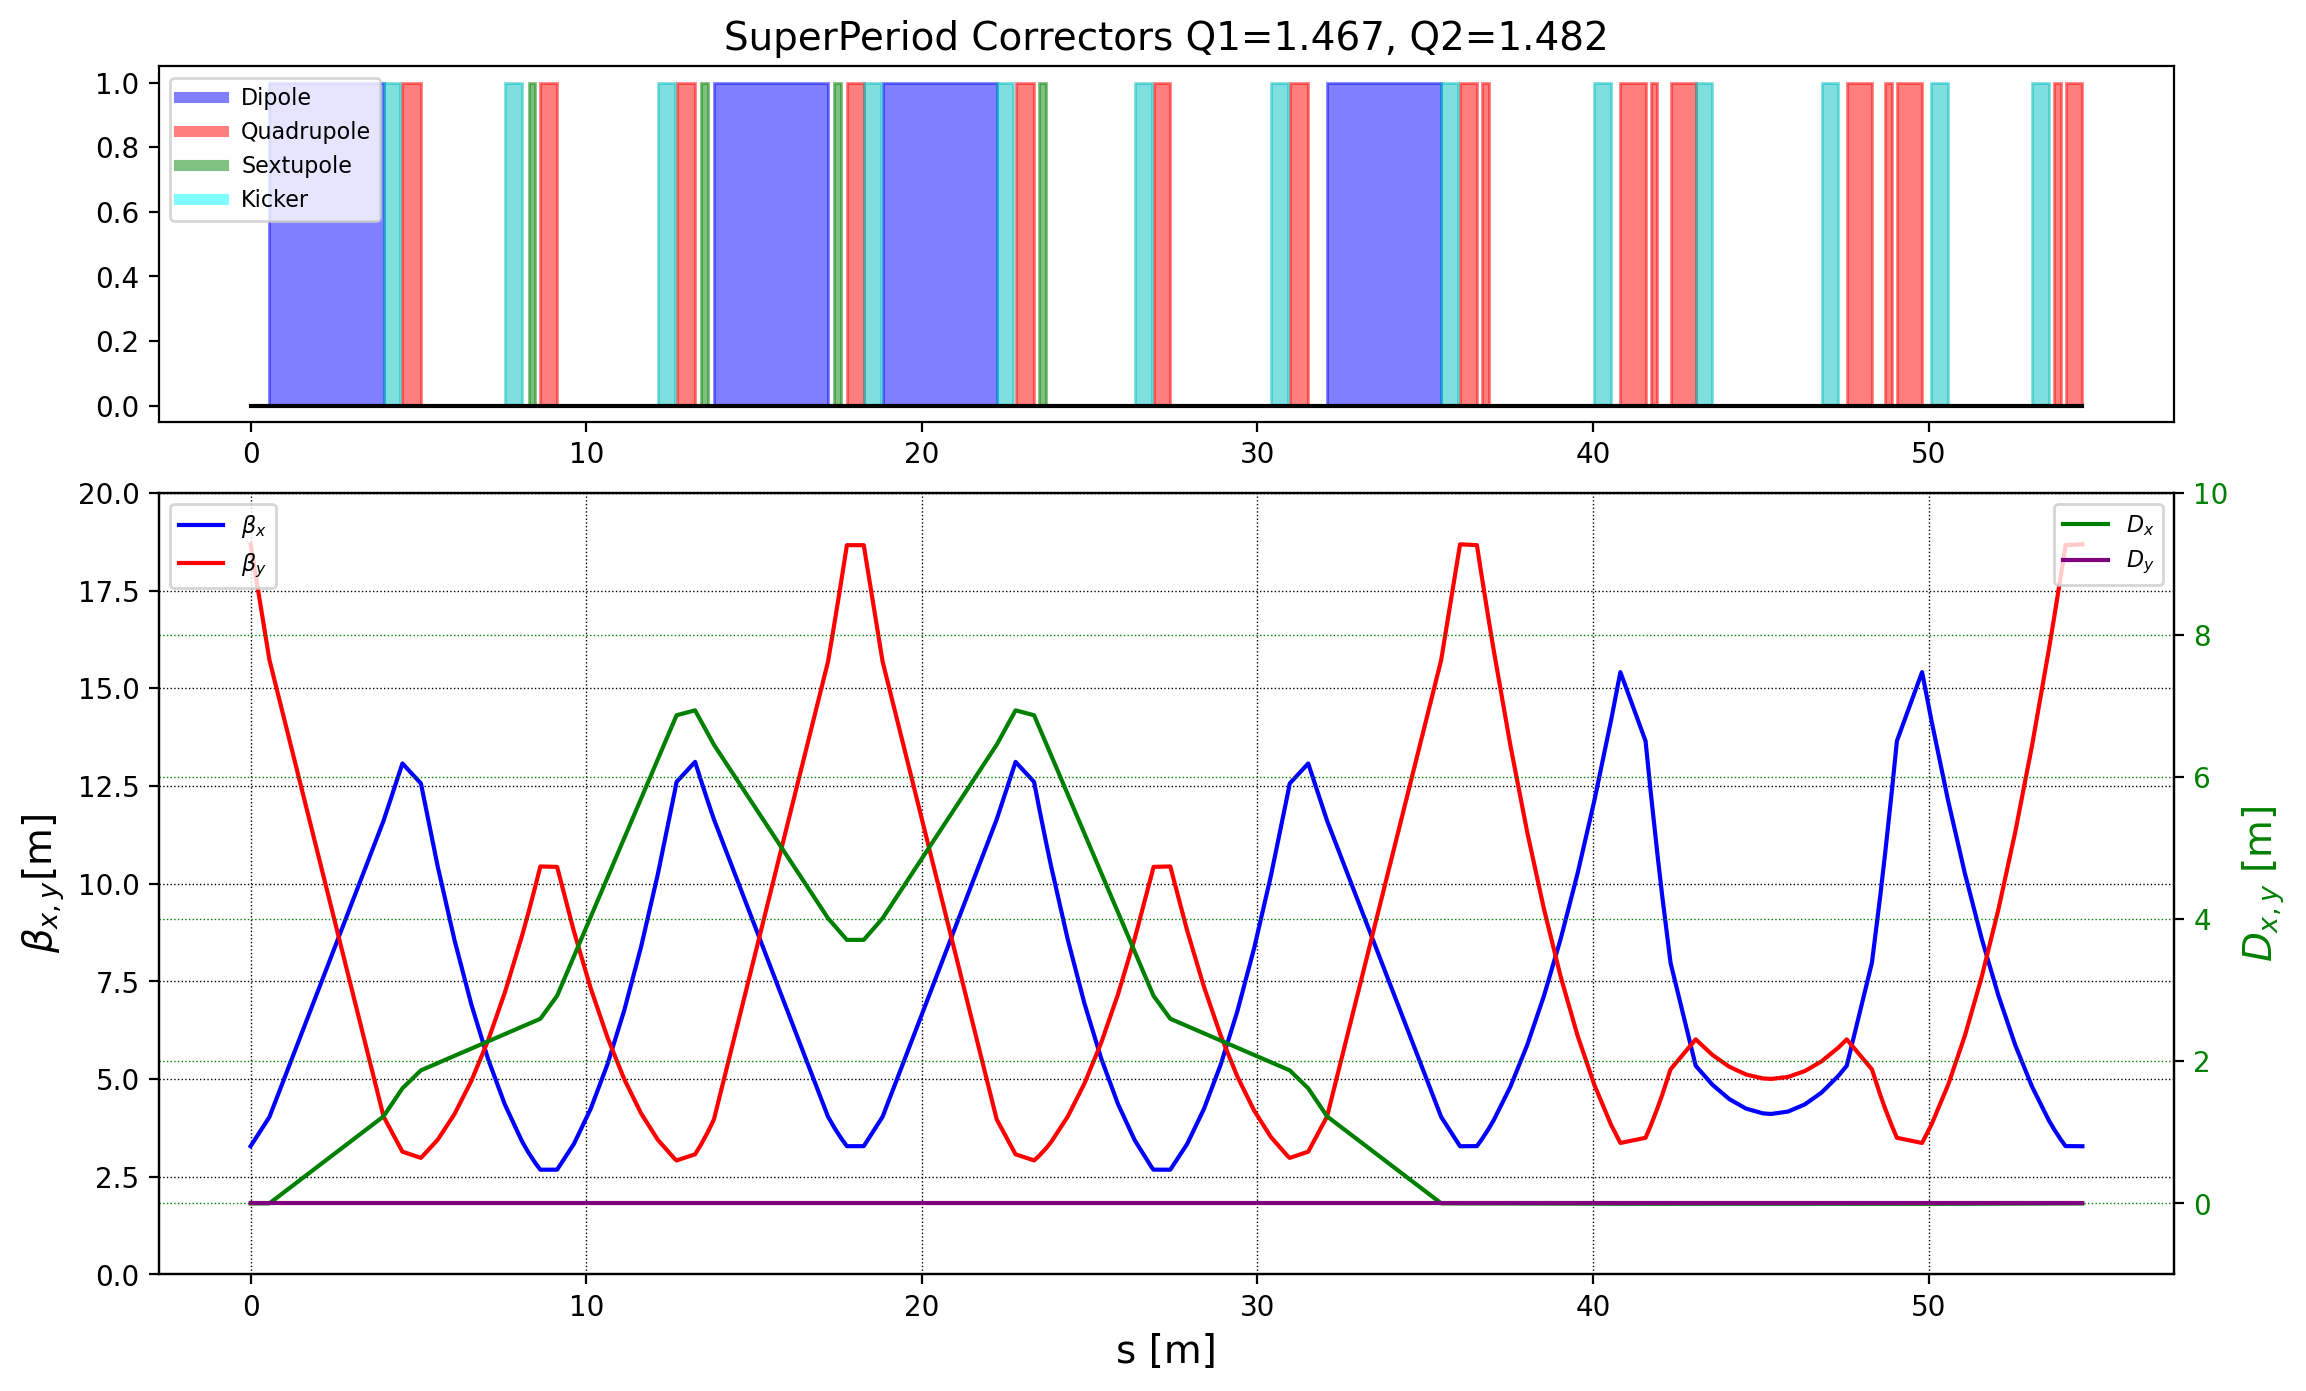

In [15]:
sp_twiss_file = 'sp_corr_madx_twiss.tfs'
madx_twiss_ring = cpymad_madx_twiss(madx, cpymad_logfile, 'sp_corr', file_out=str(save_folder+sp_twiss_file))
cpymad_plot_madx_twiss_block(madx, madx_twiss_ring, 'SuperPeriod Correctors', str(save_folder+'madx_twiss_sp_corr.png'))


Sequence ring_corr_ind exists in this instance of MAD-X
Active sequence:

{'sp_corr': <Sequence: sp_corr>, 'ring_corr_ind': <Sequence: ring_corr_ind>}


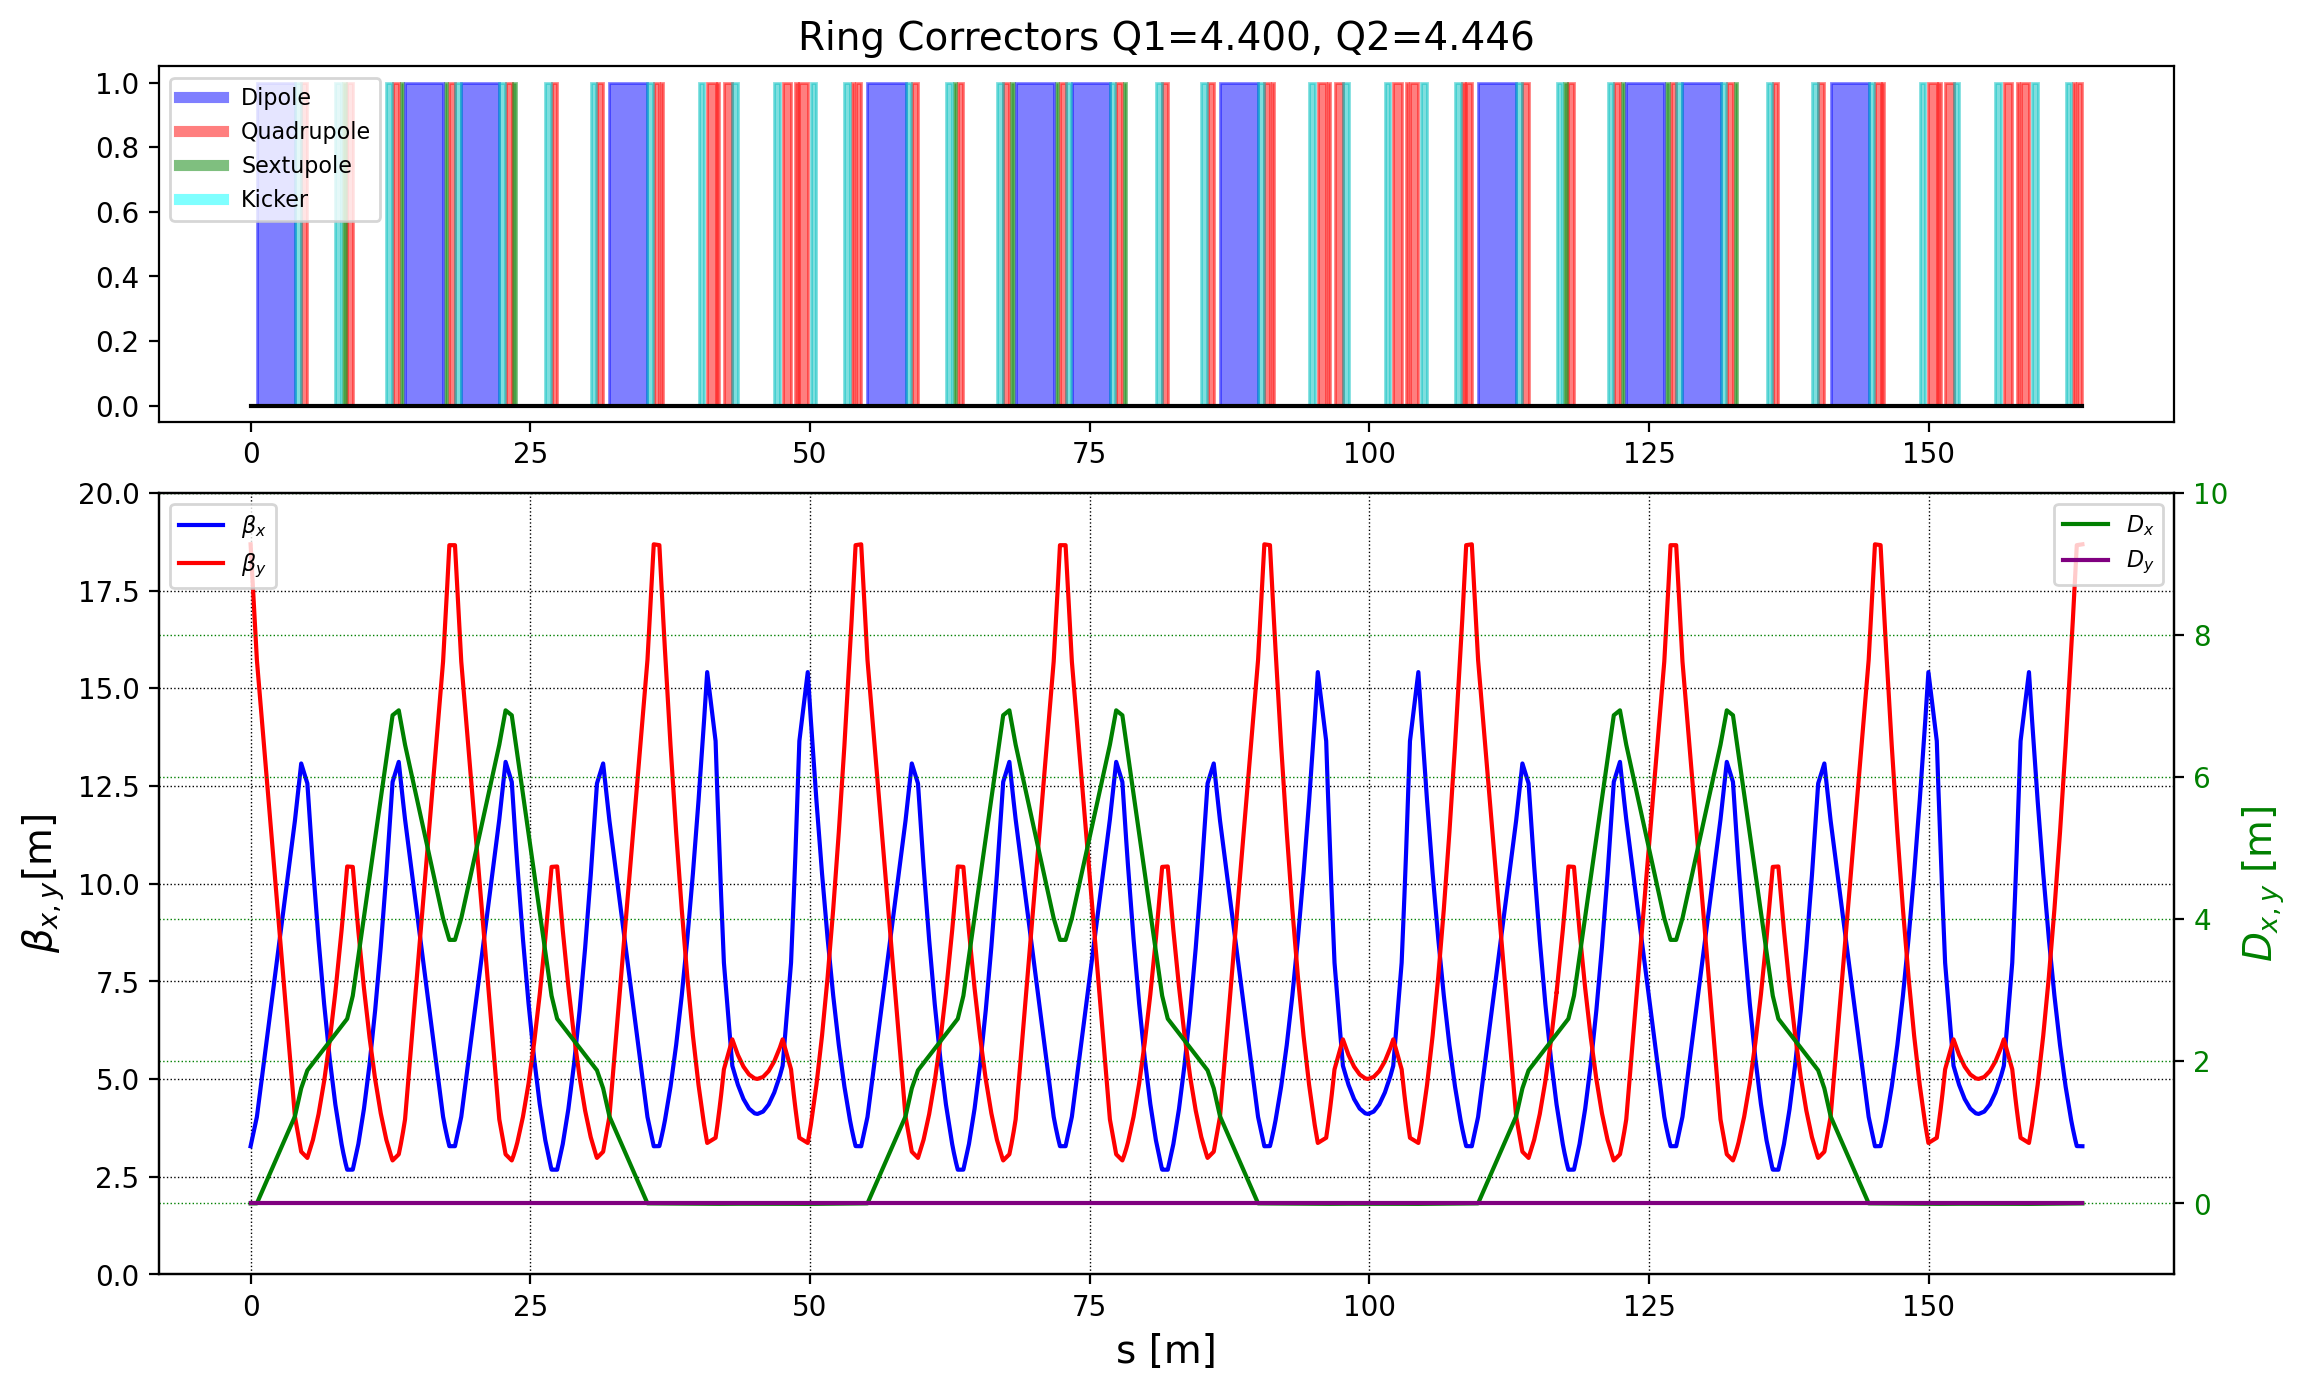

In [16]:
ring_twiss_file = 'ring_corr_ind.tfs'
madx_twiss_ring = cpymad_madx_twiss(madx, cpymad_logfile, 'ring_corr_ind', file_out=str(save_folder+ring_twiss_file))
cpymad_plot_madx_twiss_block(madx, madx_twiss_ring, 'Ring Correctors', str(save_folder+'madx_ring_corr_twiss.png'))

# Match Tunes
- Constrain Dispersion to be 0 in straight
- Constrain maximum beta functions at centre straight

In [17]:
beta_limits = [5.3395, 6.0154]
beta_limits = [5.34, 6.02]
tunes = [4.4, 4.32]

In [18]:
match_tune(madx, 'ring_corr_ind', tunes[0], tunes[1], beta_limits)

In [19]:
output_line = cpymad_print_output(cpymad_logfile, output_line)

enter Twiss module

++++++ table: summ

      length       orbit5         alfa      gammatr 
54.582895448000 -0.000000000000 0.076004763717 3.627267572878 

          q1          dq1      betxmax        dxmax 
1.466700221331 -2.132238564028 15.411987086829 6.938618377810 

       dxrms       xcomax       xcorms           q2 
3.020360459633 0.000000000000 0.000000000000 1.482030653210 

         dq2      betymax        dymax        dyrms 
-2.180801679538 18.682060492961 -0.000000000000 0.000000000000 

      ycomax       ycorms       deltap      synch_1 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 

     synch_2      synch_3      synch_4      synch_5 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 

     synch_6      synch_8       nflips 
0.000000000000 0.000000000000 0.000000000000 
enter Twiss module

++++++ table: summ

      length       orbit5         alfa      gammatr 
163.748686344000 -0.000000000000 0.076004763717 3.627267572878 

          q1       

Sequence ring_corr_ind exists in this instance of MAD-X
Active sequence:

{'sp_corr': <Sequence: sp_corr>, 'ring_corr_ind': <Sequence: ring_corr_ind>}


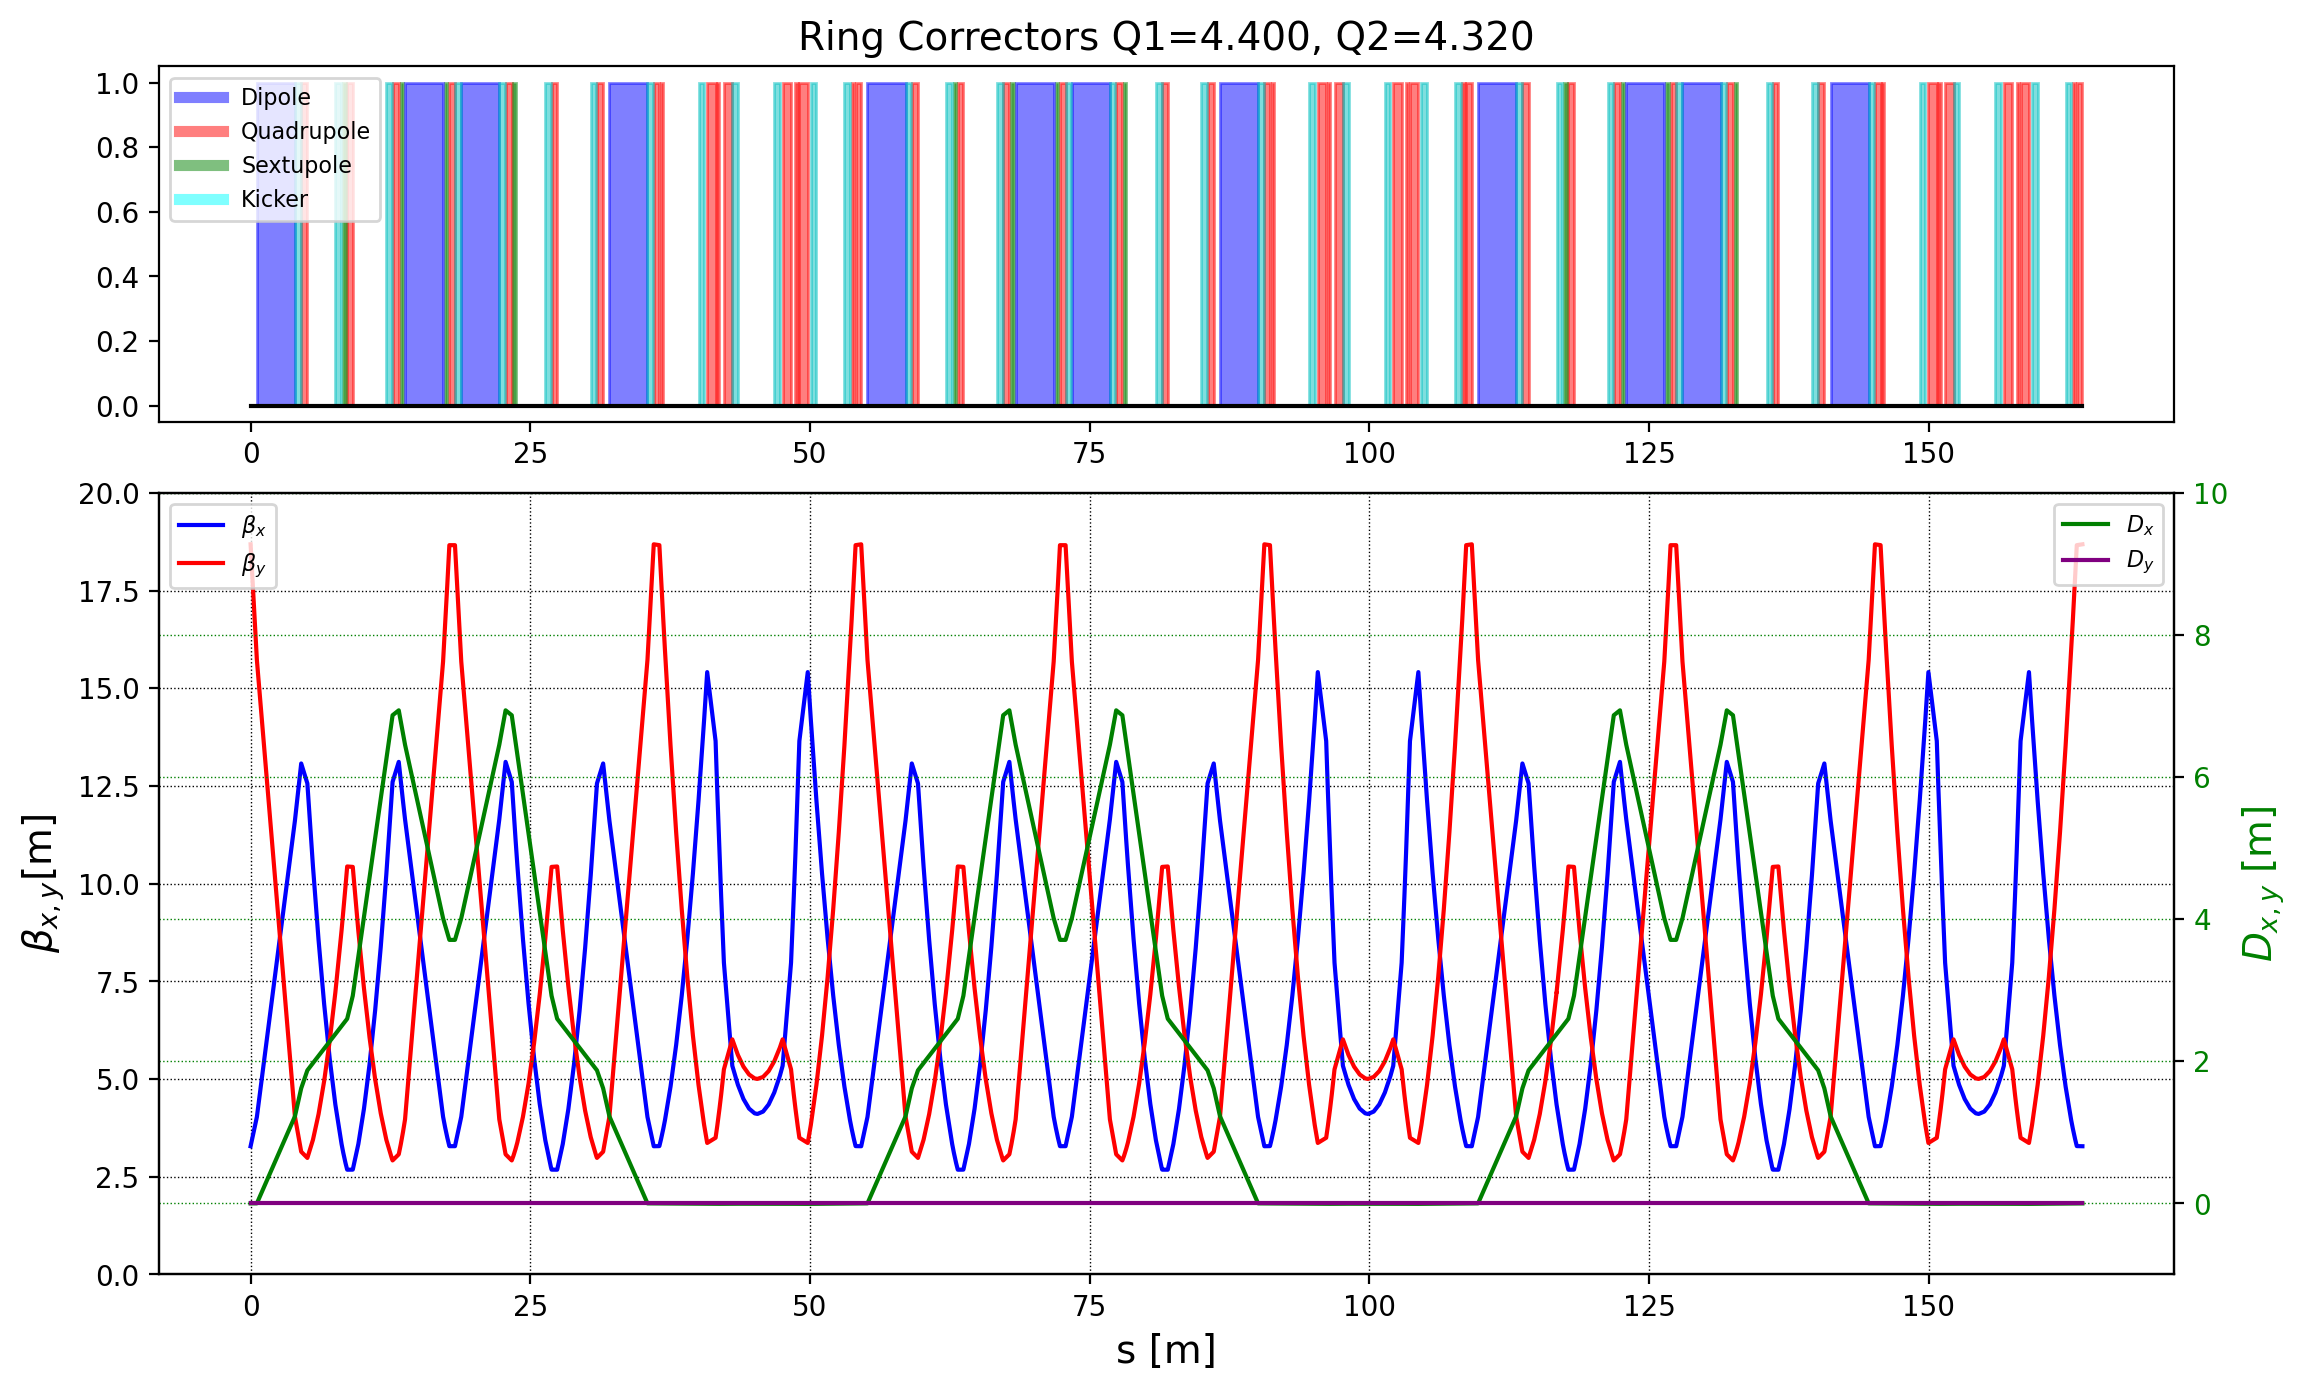

In [20]:
ring_twiss_file = 'ring_corr_ind_matched.tfs'
madx_twiss_ring_matched = cpymad_madx_twiss(madx, cpymad_logfile, 'ring_corr_ind', file_out=str(save_folder+ring_twiss_file))
cpymad_plot_madx_twiss_block(madx, madx_twiss_ring, 'Ring Correctors', str(save_folder+'madx_ring_corr_twiss_matched.png'))

In [21]:
cpymad_implement_cod_errors(madx, cpymad_logfile, 'ring_corr_ind', 'error_test_file.dat', use_errors='jparc')

In [22]:
output_line = cpymad_print_output(cpymad_logfile, output_line)

enter Twiss module

++++++ table: summ

      length       orbit5         alfa      gammatr 
163.748686344000 -0.000000000000 0.076004764248 3.627267560208 

          q1          dq1      betxmax        dxmax 
4.400001049362 -6.349586691333 15.123225106376 6.938650632167 

       dxrms       xcomax       xcorms           q2 
3.035067233605 0.000000000000 0.000000000000 4.320000715119 

         dq2      betymax        dymax        dyrms 
-6.420365140474 19.748675675029 0.000000000000 0.000000000000 

      ycomax       ycorms       deltap      synch_1 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 

     synch_2      synch_3      synch_4      synch_5 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 

     synch_6      synch_8       nflips 
0.000000000000 0.000000000000 0.000000000000 
Assigned alignment errors to 51 elements
Assigned field errors to 51 elements
Assigned alignment errors to 12 elements
Assigned field errors to 12 elements
Assigned alignment er

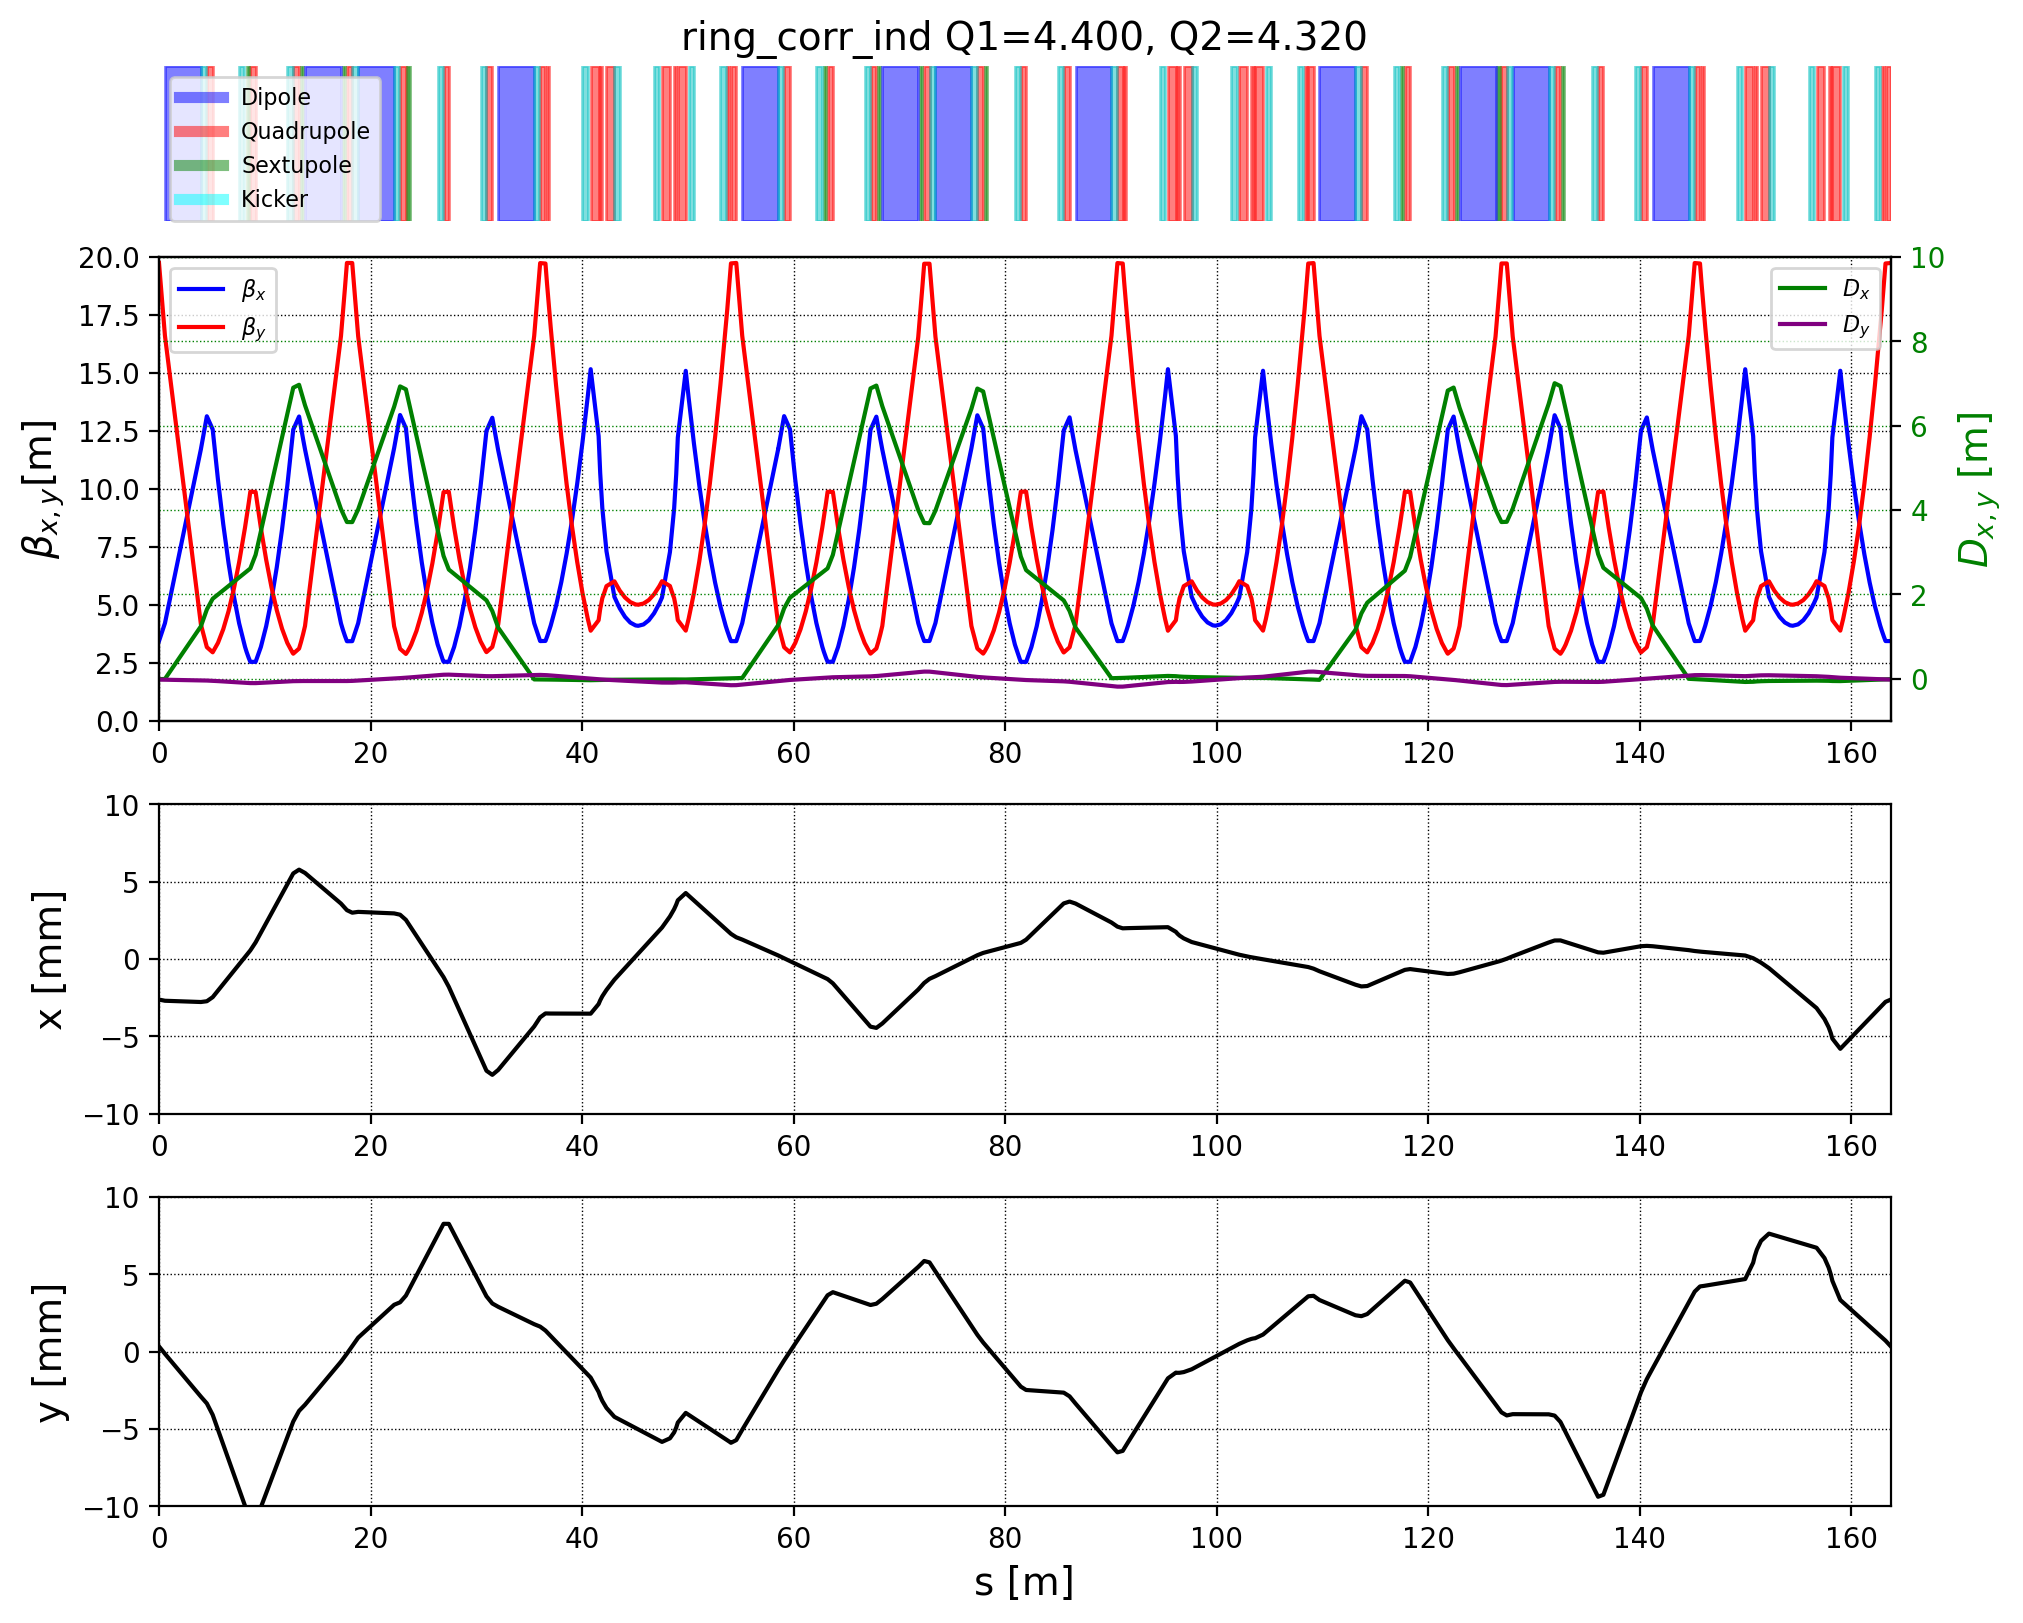

In [23]:
ring_twiss_file = 'ring_corr_madx_twiss_cod_test.tfs'
madx_twiss_ring_cod = cpymad_madx_twiss_nocheck(madx, cpymad_logfile, 'ring_corr_ind', file_out=str(save_folder+ring_twiss_file))
cpymad_plot_CO(madx, madx_twiss_ring_cod, 'ring_corr_ind', 'test_save.png', ptc_twiss=False)

In [24]:
output_line = cpymad_print_output(cpymad_logfile, output_line)

enter Twiss module

++++++ table: summ

      length       orbit5         alfa      gammatr 
163.748686344000 -0.000000000000 0.076080976072 3.625450352049 

          q1          dq1      betxmax        dxmax 
4.399618644548 -6.348370778924 15.158188527592 7.004981926176 

       dxrms       xcomax       xcorms           q2 
3.035842711072 0.007485146625 0.002462502985 4.319928121323 

         dq2      betymax        dymax        dyrms 
-6.417495179800 19.734212004122 0.183025294204 0.079157734741 

      ycomax       ycorms       deltap      synch_1 
0.010952423983 0.004474670814 0.000000000000 0.000000000000 

     synch_2      synch_3      synch_4      synch_5 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 

     synch_6      synch_8       nflips 
0.000000000000 0.000000000000 0.000000000000 


### Erase error table by calling `USE` 

In [25]:
cpymad_check_and_use_sequence(madx, cpymad_logfile, 'ring_corr_ind')

Sequence ring_corr_ind exists in this instance of MAD-X
Active sequence:

{'sp_corr': <Sequence: sp_corr>, 'ring_corr_ind': <Sequence: ring_corr_ind>}


True

In [26]:
# Set errors using file (?)
madx_command = 'readtable, file="error_test_file.dat", table = err_tab;'
madx.input(madx_command)    
madx_command = '''
seterr, table = err_tab;
'''
madx.input(madx_command)

True

In [27]:
output_line = cpymad_print_output(cpymad_logfile, output_line)

Want to make named table: err_tab
Want to use named table: err_tab
The table ==> err_tab <=== was found 


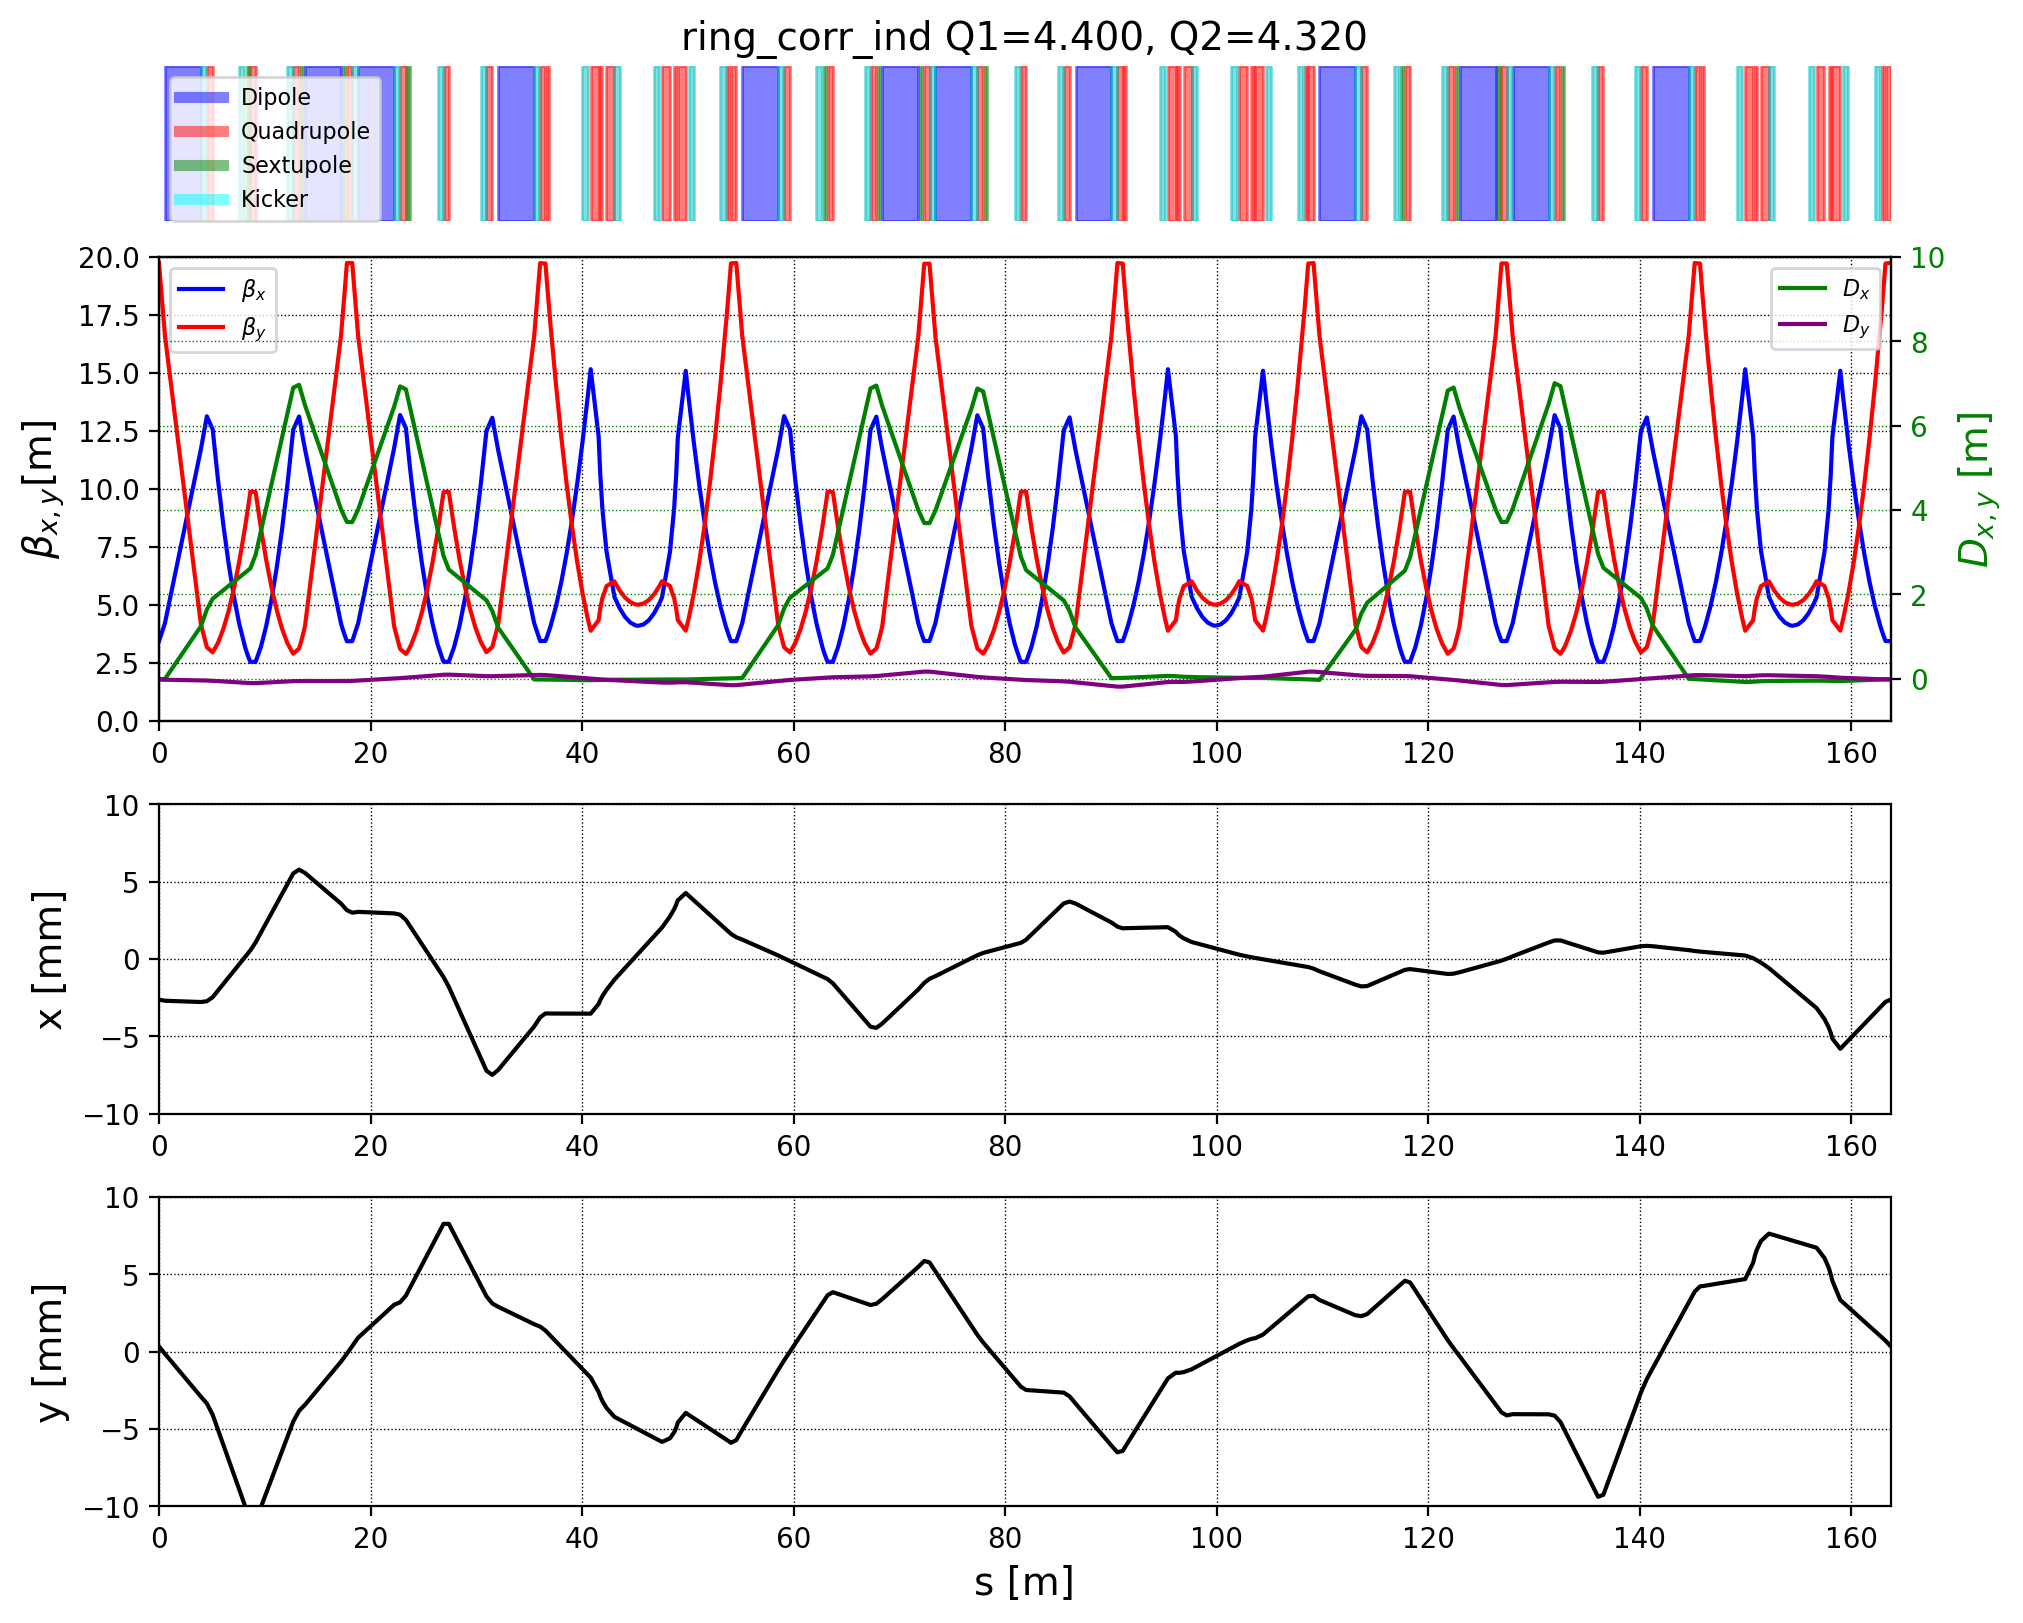

In [28]:
ring_twiss_file = 'ring_corr_madx_twiss_cod_test2.tfs'
madx_twiss_ring_cod2 = cpymad_madx_twiss_nocheck(madx, cpymad_logfile, 'ring_corr_ind', file_out=str(save_folder+ring_twiss_file))
cpymad_plot_CO(madx, madx_twiss_ring_cod2, 'ring_corr_ind', 'test_save2.png', ptc_twiss=False)

/home/HR/Repositories/cpymad/Scripts/cpymad_helpers.py:962: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  f2_ax4.set_ylim(co_min,co_max)
/home/HR/Repositories/cpymad/Scripts/cpymad_helpers.py:963: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  f2_ax3.set_ylim(co_min,co_max)


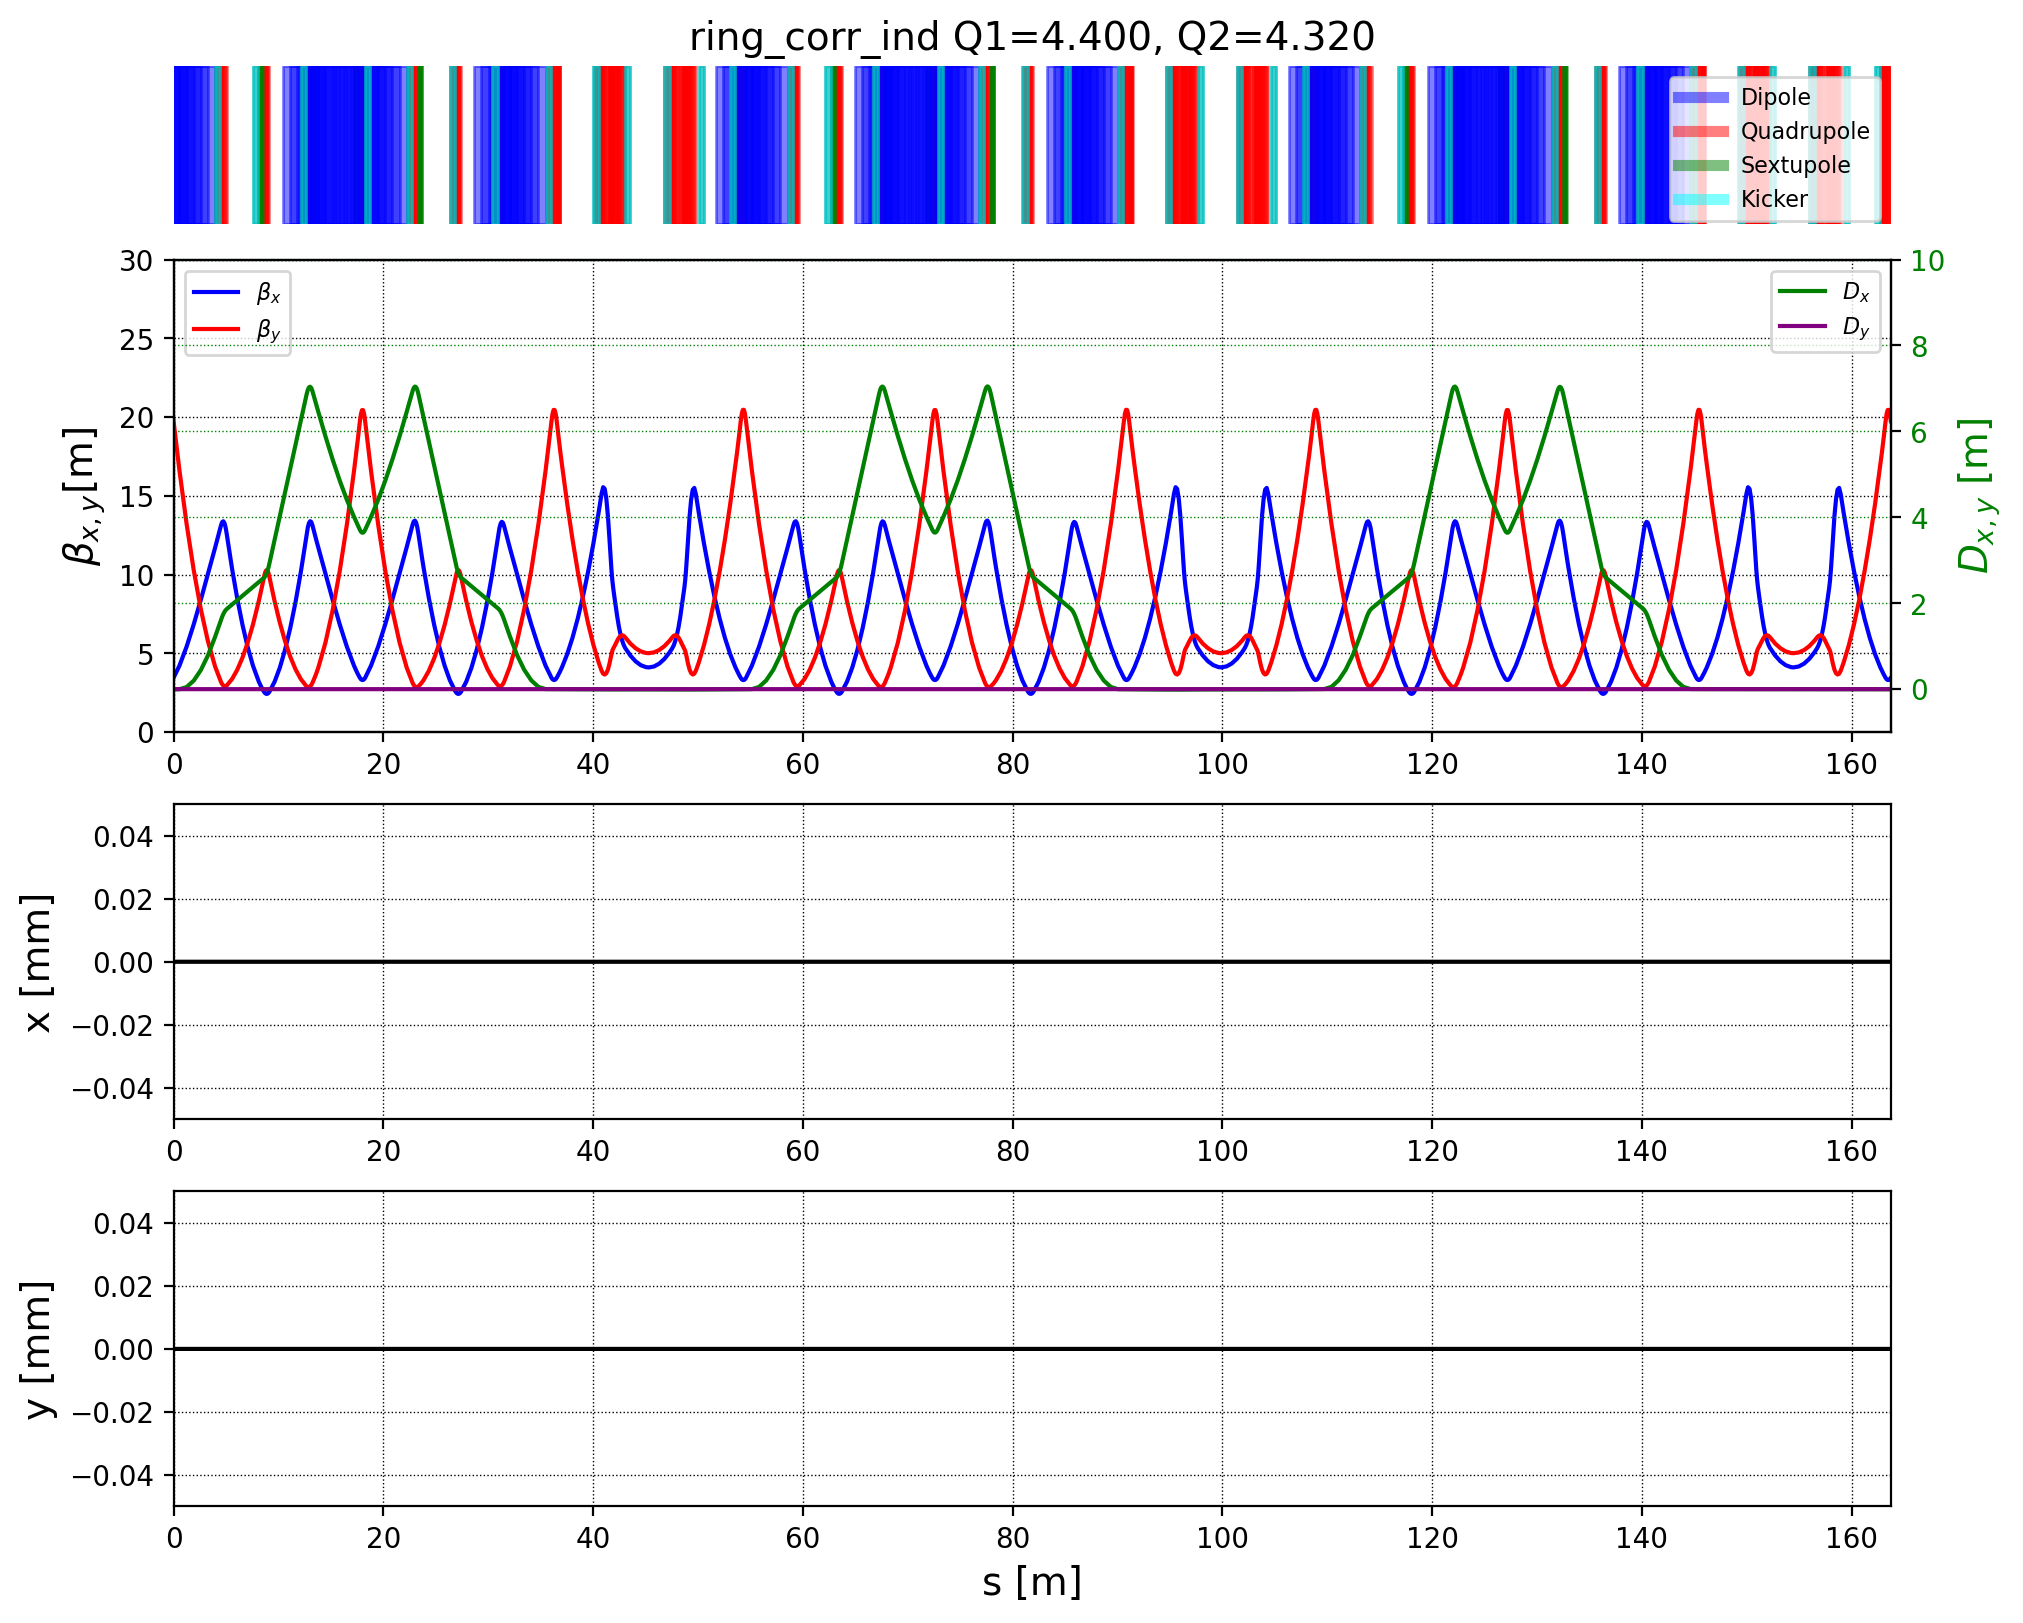

In [29]:
ptc_twiss_ring = cpymad_ptc_twiss_nocheck(madx, cpymad_logfile, 'ring_corr_ind', file_out=str('ring_corr_ptc_twiss_cod_test.tfs'))
cpymad_plot_CO(madx, ptc_twiss_ring, 'ring_corr_ind', 'test_save_ptc.png', ptc_twiss=True, beta_rel=0.713)

In [30]:
output_line = cpymad_print_output(cpymad_logfile, output_line)

enter Twiss module

++++++ table: summ

      length       orbit5         alfa      gammatr 
163.748686344000 -0.000000000000 0.076080976072 3.625450352047 

          q1          dq1      betxmax        dxmax 
4.399618644549 -6.348370778923 15.158188527735 7.004981926154 

       dxrms       xcomax       xcorms           q2 
3.035842711072 0.007485146628 0.002462502985 4.319928121324 

         dq2      betymax        dymax        dyrms 
-6.417495179808 19.734212004166 0.183025294230 0.079157734752 

      ycomax       ycorms       deltap      synch_1 
0.010952423983 0.004474670815 0.000000000000 0.000000000000 

     synch_2      synch_3      synch_4      synch_5 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 

     synch_6      synch_8       nflips 
0.000000000000 0.000000000000 0.000000000000 
a4a_28:1                   dx           2     0.00000000E+00    -2.16503720E-03     0.00000000E+00
a4a_29:1                   dx           2     0.00000000E+00    -2.85274468E-0

# Implement Correction of COD

In [31]:
def cpymad_plot_CO_correction(madx_instance, df_myTwiss, df_myTwiss2, sequence_name, save_file, ptc_twiss=False, beta_rel=None):
        
    if ptc_twiss:
        if beta_rel == None:
            print('cpymad_plot_CO: Error: ptc_twiss selected but no beta_rel supplied for dispersion normalisation')
            return False
    
    # Plot title = sequence_name + tunes
    qx = madx_instance.table.summ.q1[0]
    qy = madx_instance.table.summ.q2[0]     
    plot_title = sequence_name +' Q1='+format(qx,'2.3f')+', Q2='+ format(qy,'2.3f')
    
    # Start Plot
    heights = [1, 3, 2, 2]
    fig2 = plt.figure(figsize=(10,8),facecolor='w', edgecolor='k',constrained_layout=True);
    spec2 = gridspec.GridSpec(ncols=1, nrows=4, figure=fig2, height_ratios=heights);
    
    # Block diagram
    f2_ax1 = fig2.add_subplot(spec2[0]);
    f2_ax1.set_title(plot_title);  
    
    if ptc_twiss:
        block_diagram(f2_ax1, df_myTwiss, ptc_twiss=True)
    else: 
        block_diagram(f2_ax1, df_myTwiss, ptc_twiss=False)
    
    # Plot betas   
    f2_ax2 = fig2.add_subplot(spec2[1], sharex=f2_ax1);  
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['betx'],'b', label='$\\beta_x$');
    f2_ax2.plot(df_myTwiss['s'], df_myTwiss['bety'],'r', label='$\\beta_y$');  
    
    f2_ax2.legend(loc=2);
    f2_ax2.set_ylabel(r'$\beta_{x,y}$[m]');
    f2_ax2.grid(which='both', ls=':', lw=0.5, color='k');
    #f2_ax2.set_xlabel('s [m]')
    #f2_ax2.set_xticklabels([])
    
    if np.min(df_myTwiss['bety']) < np.min(df_myTwiss['betx']): bet_min = round_down_n(np.min(df_myTwiss['bety']),5)
    else: bet_min = round_down_n(np.min(df_myTwiss['betx']),5)
    if np.max(df_myTwiss['bety']) > np.max(df_myTwiss['betx']): bet_max = round_up_n(np.max(df_myTwiss['bety']),10)
    else: bet_max = round_up_n(np.max(df_myTwiss['betx']),10)        
    f2_ax2.set_ylim(bet_min,bet_max);
    
    ax2 = f2_ax2.twinx();   # instantiate a second axes that shares the same x-axis
    if ptc_twiss:     
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp1']/beta_rel,'green', label='$D_x$');
        ax2.plot(df_myTwiss['s'], df_myTwiss['disp3']/beta_rel,'purple', label='$D_y$');
        key_dx = 'disp1';        key_dy = 'disp3';  
    
    else:
        ax2.plot(df_myTwiss['s'], df_myTwiss['dx'],'green', label='$D_x$');
        ax2.plot(df_myTwiss['s'], df_myTwiss['dy'],'purple', label='$D_y$');
        key_dx = 'dx';        key_dy = 'dy';  
        
    ax2.legend(loc=1);
    ax2.set_ylabel(r'$D_{x,y}$ [m]', color='green');  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor='green');
    ax2.grid(which='both', ls=':', lw=0.5, color='green');

    if np.min(df_myTwiss[key_dy]) < np.min(df_myTwiss[key_dx]): d_min = round_down_n(np.min(df_myTwiss[key_dy]),1)
    else: d_min = round_down_n(np.min(df_myTwiss[key_dx]),1)    
    if np.max(df_myTwiss[key_dy]) > np.max(df_myTwiss[key_dx]): d_max = round_up_n(np.max(df_myTwiss[key_dy]),10)
    else: d_max = round_up_n(np.max(df_myTwiss[key_dx]),10) 
    ax2.set_ylim(d_min,d_max);
   
    # Include standard deviations (RMS in mm) of orbits on plots 
    if np.std(df_myTwiss2['x']) == 0.0:
        print('cpymad_plot_CO_correction: Error: Uncorrected closed orbit is not perturbed, please apply errors')
        return False
    std_x = round_sig(np.std(df_myTwiss2['x'])*1E3,3)
    std_x_corr = round_sig(np.std(df_myTwiss['x'])*1E3,3)
    txt_x = r'$x_{RMS}$ = ' + str(std_x) + ' mm\n' + r'$x_{corrected~RMS}$ = '+ str(std_x_corr)+ ' mm'
    std_y = round_sig(np.std(df_myTwiss2['y'])*1E3,3)
    std_y_corr = round_sig(np.std(df_myTwiss['y'])*1E3,3)
    txt_y = r'$y_{RMS}$ = ' + str(std_y) + ' mm\n' + r'$y_{corrected~RMS}$ = '+ str(std_y_corr)+ ' mm'
    
    f2_ax3 = fig2.add_subplot(spec2[2], sharex=f2_ax1);
    f2_ax3.plot(df_myTwiss2['s'], df_myTwiss2['x']*1E3,'r', lw=1.5, label='$x$');
    f2_ax3.plot(df_myTwiss['s'], df_myTwiss['x']*1E3,'k', lw=1.5, label='$x_{corrected}$');     
    #f2_ax3.legend(loc=2)
    f2_ax3.set_ylabel('x [mm]');
    f2_ax3.grid(which='both', ls=':', lw=0.5, color='k');
    f2_ax3.text(np.max(df_myTwiss['s'])/2, 5, txt_x, fontsize=10);
    
    f2_ax4 = fig2.add_subplot(spec2[3], sharex=f2_ax1);
    f2_ax4.plot(df_myTwiss2['s'], df_myTwiss2['y']*1E3,'r', lw=1.5, label='$y$')  ;
    f2_ax4.plot(df_myTwiss['s'], df_myTwiss['y']*1E3,'k', lw=1.5, label='$y_{corrected}$');   
    f2_ax4.set_ylabel('y [mm]');
    f2_ax4.grid(which='both', ls=':', lw=0.5, color='k');
    f2_ax4.text(np.max(df_myTwiss['s'])/2, 5, txt_y, fontsize=10);
    
    if np.min(df_myTwiss['y']) < np.min(df_myTwiss['x']): co_min = round_down_n(np.min(df_myTwiss['y']),10)
    else: co_min = round_down_n(np.min(df_myTwiss['x']),10)
    if np.max(df_myTwiss['y']) > np.max(df_myTwiss['x']): co_max = round_up_n(np.max(df_myTwiss['y']),10)
    else: co_max = round_up_n(np.max(df_myTwiss['x']),10)   
    
    f2_ax3.legend(loc=2);
    f2_ax4.legend(loc=2);
    
    f2_ax3.set_ylim(co_min,co_max);
    f2_ax4.set_ylim(co_min,co_max);
    
    f2_ax4.set_xlabel('s [m]');
    
    #f2_ax4 = fig2.add_subplot(spec2[4], sharex=f2_ax1)   
    if save_file != None: 
        plt.savefig(save_file);
        plt.close();       

In [32]:
def cpymad_correct_cod(madx_instance, cpymad_logfile, sequence_name, i=None, monitor_errors=False):
    
    if i == None: i = 0
        
    if monitor_errors:
        clist_file_x = 'clist_x_m_'+str(int(i))+'.dat'
        clist_file_y = 'clist_y_m_'+str(int(i))+'.dat'
        mlist_file_x = 'mlist_x_m_'+str(int(i))+'.dat'
        mlist_file_y = 'mlist_y_m_'+str(int(i))+'.dat'        
    else:
        clist_file_x = 'clist_x_'+str(int(i))+'.dat'
        clist_file_y = 'clist_y_'+str(int(i))+'.dat'
        mlist_file_x = 'mlist_x_'+str(int(i))+'.dat'
        mlist_file_y = 'mlist_y_'+str(int(i))+'.dat'

    # Turn on correction kickers
    madx_instance.command.usekick(sequence=sequence_name, status="on", pattern="^hc.*.*.*")
    
    # Turn on monitors
    madx_instance.command.usemonitor(sequence=sequence_name, status="on", class_="monitor")

    # Create twiss table for uncorrected orbit
    file_out = sequence_name +'_madx_twiss_uncorrected_' + str(i) + '.tfs'
    madx_instance.input('set, format="12.12f"')
    madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
    madx_instance.twiss(sequence=sequence_name, file=file_out, table='uncorrected')
    
    # correct horizontal orbit using uncorr table. cond = 1 forces SVD    
    if monitor_errors:
        madx_instance.command.correct(model='uncorrected',sequence=sequence_name, plane="x", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=1, monscale=1, clist=clist_file_x, mlist=mlist_file_x)
    else:
        madx_instance.command.correct(model='uncorrected',sequence=sequence_name, plane="x", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=0, monscale=0, clist=clist_file_x, mlist=mlist_file_x)
    
    # Turn on correction kickers
    madx_instance.command.usekick(sequence=sequence_name, status="on", pattern="^vc.*.*.*")
    
    # Turn on monitors
    madx_instance.command.usemonitor(sequence=sequence_name, status="on", class_="monitor")

    # Create twiss table for vertical orbit correction
    file_out = sequence_name +'_madx_twiss_x_corrected_' + str(i) + '.tfs'
    madx_instance.input('set, format="12.12f"')
    madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
    madx_instance.twiss(sequence=sequence_name, file=file_out, table='x_corrected')
    
    # correct horizontal orbit using uncorr table. cond = 1 forces SVD    
    if monitor_errors:
        madx_instance.command.correct(model='x_corrected',sequence=sequence_name, plane="y", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=1, monscale=1, clist=clist_file_y, mlist=mlist_file_y)
    else:
        madx_instance.command.correct(model='x_corrected',sequence=sequence_name, plane="y", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=0, monscale=0, clist=clist_file_y, mlist=mlist_file_y)   
    
    ## Create corrected twiss table for save and plot
    file_out = sequence_name +'_madx_twiss_corrected_' + str(i) + '.tfs'
    madx_instance.input('set, format="12.12f"')
    madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
    madx_instance.twiss(sequence=sequence_name, file=file_out, table='corrected')
        
    if monitor_errors:
        plot_save_file = 'COD_Correction_m_' + str(i) + '.png'
    else:
        plot_save_file = 'COD_Correction_' + str(i) + '.png'
        
    cpymad_plot_CO_correction(madx_instance, madx_instance.table.corrected.dframe(), madx_instance.table.uncorrected.dframe(), sequence_name, plot_save_file)        

In [33]:
cpymad_correct_cod(madx, cpymad_logfile, 'ring_corr_ind', 72)

In [34]:
cpymad_implement_cod_errors(madx, cpymad_logfile, 'ring_corr_ind', 'error_test_file.dat', use_errors='jparc')

In [35]:
cpymad_correct_cod(madx, cpymad_logfile, 'ring_corr_ind', 69, True)

In [36]:
output_line = cpymad_print_output(cpymad_logfile, output_line)

++++++ info: 18 corrector(s) affected
++++++ info: 39 monitor(s) affected
enter Twiss module

++++++ table: summ

      length       orbit5         alfa      gammatr 
163.748686344000 -0.000000000000 0.076080976072 3.625450352047 

          q1          dq1      betxmax        dxmax 
4.399618644549 -6.348370778923 15.158188527735 7.004981926154 

       dxrms       xcomax       xcorms           q2 
3.035842711072 0.007485146628 0.002462502985 4.319928121324 

         dq2      betymax        dymax        dyrms 
-6.417495179808 19.734212004166 0.183025294230 0.079157734752 

      ycomax       ycorms       deltap      synch_1 
0.010952423983 0.004474670815 0.000000000000 0.000000000000 

     synch_2      synch_3      synch_4      synch_5 
0.000000000000 0.000000000000 0.000000000000 0.000000000000 

     synch_6      synch_8       nflips 
0.000000000000 0.000000000000 0.000000000000 
Want to correct orbit of a single ring
Want to use model orbit from: uncorrected
39 monitors and 18 cor

# Test reading of created MAD-X files 

## Use tfs

> Loading a TFS file is simple
>
> `data_frame = tfs.read("path_to_input.tfs", index="index_column")`
>
> You can access and modify the headers with the .headers attribute
> 
> `useful_variable = data_frame.headers["SOME_KEY"]`
> 
> `data_frame.headers["NEW_KEY"] = some_variable`
>
> Manipulate data as you do with pandas DataFrames
>
> `data_frame["NEWCOL"] = data_frame.COL_A * data_frame.COL_B`
>
> You can check the validity of a TfsDataFrame, and choose the behavior in case of errors
> `tfs.frame.validate(data_frame, non_unique_behavior="raise")`  # or choose "warn"
> 
> Writing out to disk is simple too
> `tfs.write("path_to_output.tfs", data_frame, save_index="index_column")`

In [37]:
c_list_test_df = tfs.read('clist_y_72.dat')
y_correction_rms = np.std(c_list_test_df['PY.CORRECTION'])*1e3
y_correction_min = np.min(c_list_test_df['PY.CORRECTION'])*1e3
y_correction_max = np.max(c_list_test_df['PY.CORRECTION'])*1e3
c_list_test_df = tfs.read('clist_x_72.dat')
x_correction_rms = np.std(c_list_test_df['PX.CORRECTION'])*1e3
x_correction_min = np.min(c_list_test_df['PX.CORRECTION'])*1e3
x_correction_max = np.max(c_list_test_df['PX.CORRECTION'])*1e3

In [38]:
print(y_correction_rms)
#print(y_correction_min)
print(y_correction_max)
print(x_correction_rms)
#print(x_correction_min)
print(x_correction_max)

0.21650128667792792
1.0384337369999999
0.10548843705856825
0.360171136


In [39]:
m_list_test_df = tfs.read('mlist_y_72.dat')
m_list_test_df

,NAME,X.OLD,Y.OLD,X,Y
0,HM101,0.0,-0.002909,0.0,-0.000024
1,VM102,0.0,-0.008888,0.0,-0.000041
2,HM102,0.0,-0.005522,0.0,0.000048
3,VM103,0.0,0.000359,0.0,0.001267
4,HM103,0.0,0.003031,0.0,0.001885
5,VM104,0.0,0.007537,0.0,0.002770
6,HM104,0.0,0.004314,0.0,0.001435
7,VM105,0.0,0.001773,0.0,0.000375
8,HM105,0.0,-0.001126,0.0,-0.000338
9,VM107,0.0,-0.004214,0.0,-0.001118


In [40]:
e_list_test_df = tfs.read('error_test_file.dat')
e_list_test_df

,NAME,K0L,K0SL,K1L,K1SL,K2L,K2SL,K3L,K3SL,K4L,...,P16L,P16SL,P17L,P17SL,P18L,P18SL,P19L,P19SL,P20L,P20SL
0,RING_CORR_IND$START,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A0_0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,B1_0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HM101,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HC101,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404,A4C_10,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
405,QTD_5,0.0,0.0,-5.837860e-07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
406,A4C_11,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407,QD3_5,-0.0,0.0,-5.820606e-05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
uncorr_df = tfs.read('ring_corr_ind_madx_twiss_uncorrected_72.tfs')
print(uncorr_df.headers["XCOMAX"]*1E3)
print(uncorr_df.headers["XCORMS"]*1E3)
print(uncorr_df.headers["YCOMAX"]*1E3)
print(uncorr_df.headers["YCORMS"]*1E3)

7.485146628
2.462502985
10.952423983000001
4.474670815


# Read TFS table: create dataframe
Store:
- [ ] horizontal closed orbits in dataframe
- [ ] vertical closed orbits in dataframe

Append: column for every read tfs table (some sort of check for number of elements, s positions etc

Read tfs tables into TFS Dataframes

In [43]:
tfs_filename = 'COD_test.tfs'
df_in = tfs.read(tfs_filename)
tfs_filename1 = 'COD_test1.tfs'
df_in1 = tfs.read(tfs_filename1)

In [44]:
test_list = df_in.X

In [45]:
test_list[0]

5.0831862e-05

In [46]:
len(test_list)

410

Create a dataframe using the intersection of two columns

In [47]:
x_df = df_in.loc[:, df_in.columns.intersection(['S','X'])]

In [48]:
x_df

,S,X
0,0.000000,0.000051
1,0.561757,0.000009
2,3.961757,-0.000238
3,3.961757,-0.000238
4,3.961757,-0.000238
...,...,...
405,163.096247,0.000099
406,163.246247,0.000088
407,163.748686,0.000051
408,163.748686,0.000051


We can also create an empty dataframe and fill it with lists - this will create a pure pandas dataframe rather than TFS dataframe

In [49]:
df_proper_test = pnd.DataFrame()

In [50]:
df_proper_test['S'] = df_in.S

In [51]:
df_proper_test['X'] = df_in.X

In [52]:
df_proper_test

,S,X
0,0.000000,0.000051
1,0.561757,0.000009
2,3.961757,-0.000238
3,3.961757,-0.000238
4,3.961757,-0.000238
...,...,...
405,163.096247,0.000099
406,163.246247,0.000088
407,163.748686,0.000051
408,163.748686,0.000051


In [53]:
df_test_concat = pnd.concat([x_df,df_in1.X], axis=1)

for i in range(0,10,1):
    print(i)
    #df_test_concat = pnd.concat([df_test_concat,df_in1.X], axis=1)
    df_test_concat[('X_sqd_'+str(i))] = df_in1.X.pow(2)
    df_test_concat[('X_sqd_'+str(i+10))] = df_in.X.pow(2)

0
1
2
3
4
5
6
7
8
9


In [54]:
df_test_concat

,S,X,X,X_sqd_0,X_sqd_10,X_sqd_1,X_sqd_11,X_sqd_2,X_sqd_12,X_sqd_3,...,X_sqd_5,X_sqd_15,X_sqd_6,X_sqd_16,X_sqd_7,X_sqd_17,X_sqd_8,X_sqd_18,X_sqd_9,X_sqd_19
0,0.000000,0.000051,0.000004,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09
1,0.561757,0.000009,0.000117,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,...,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11
2,3.961757,-0.000238,0.000758,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08
3,3.961757,-0.000238,0.000758,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08
4,3.961757,-0.000238,0.000758,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,163.096247,0.000099,-0.000084,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,...,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09
406,163.246247,0.000088,-0.000070,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,...,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09
407,163.748686,0.000051,0.000004,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09
408,163.748686,0.000051,0.000004,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09


In [55]:
df_test_concat=df_test_concat.drop(['X'], axis = 1)

In [56]:
df_test_concat

,S,X_sqd_0,X_sqd_10,X_sqd_1,X_sqd_11,X_sqd_2,X_sqd_12,X_sqd_3,X_sqd_13,X_sqd_4,...,X_sqd_5,X_sqd_15,X_sqd_6,X_sqd_16,X_sqd_7,X_sqd_17,X_sqd_8,X_sqd_18,X_sqd_9,X_sqd_19
0,0.000000,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09
1,0.561757,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,...,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11
2,3.961757,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08
3,3.961757,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08
4,3.961757,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,163.096247,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,...,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09
406,163.246247,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,...,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09
407,163.748686,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09
408,163.748686,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09


In [57]:
t=19

In [58]:
df_test_concat['X_RMS'] = df_test_concat.loc[: , 'X_sqd_0':('X_sqd_'+str(t))].mean(axis=1).pow(1./2)

<ipython-input-58-b9e81172f193>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_concat['X_RMS'] = df_test_concat.loc[: , 'X_sqd_0':('X_sqd_'+str(t))].mean(axis=1).pow(1./2)


In [59]:
df_test_concat

,S,X_sqd_0,X_sqd_10,X_sqd_1,X_sqd_11,X_sqd_2,X_sqd_12,X_sqd_3,X_sqd_13,X_sqd_4,...,X_sqd_15,X_sqd_6,X_sqd_16,X_sqd_7,X_sqd_17,X_sqd_8,X_sqd_18,X_sqd_9,X_sqd_19,X_RMS
0,0.000000,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,0.000036
1,0.561757,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,...,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,1.374533e-08,7.280770e-11,0.000083
2,3.961757,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,0.000562
3,3.961757,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,0.000562
4,3.961757,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,...,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,5.747909e-07,5.658356e-08,0.000562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,163.096247,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,...,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,7.106703e-09,9.838017e-09,0.000092
406,163.246247,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,...,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,4.908242e-09,7.745604e-09,0.000080
407,163.748686,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,0.000036
408,163.748686,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,...,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,1.348070e-11,2.583878e-09,0.000036


In [60]:
columns = []
for i in range(0,20,1):
    columns.append('X_sqd_'+str(i))

In [61]:
columns

['X_sqd_0',
 'X_sqd_1',
 'X_sqd_2',
 'X_sqd_3',
 'X_sqd_4',
 'X_sqd_5',
 'X_sqd_6',
 'X_sqd_7',
 'X_sqd_8',
 'X_sqd_9',
 'X_sqd_10',
 'X_sqd_11',
 'X_sqd_12',
 'X_sqd_13',
 'X_sqd_14',
 'X_sqd_15',
 'X_sqd_16',
 'X_sqd_17',
 'X_sqd_18',
 'X_sqd_19']

In [62]:
df_test_concat.drop(columns=columns)

,S,X_RMS
0,0.000000,0.000036
1,0.561757,0.000083
2,3.961757,0.000562
3,3.961757,0.000562
4,3.961757,0.000562
...,...,...
405,163.096247,0.000092
406,163.246247,0.000080
407,163.748686,0.000036
408,163.748686,0.000036


In [63]:
from datetime import datetime
def cpymad_cod_correction_simulation_monitors_rms(madx_instance, cpymad_logfile, sequence_name, n_max):
    
    suppress_excess_output = True
    
    uncorrected_xcomax = []
    uncorrected_xcorms = []
    uncorrected_ycomax = []
    uncorrected_ycorms = []
    
    corrected_xcomax = []
    corrected_xcorms = []    
    corrected_ycomax = []
    corrected_ycorms = []
    
    corrector_xkmin = []
    corrector_xkmax = []
    corrector_xkrms = []
    corrector_ykmin = []
    corrector_ykmax = []
    corrector_ykrms = []
    
    uncorrected_xcomax_m = []
    uncorrected_xcorms_m = []
    uncorrected_ycomax_m = []
    uncorrected_ycorms_m = []
    
    corrected_xcomax_m = []
    corrected_xcorms_m = []    
    corrected_ycomax_m = []
    corrected_ycorms_m = []
    
    corrector_xkmin_m = []
    corrector_xkmax_m = []
    corrector_xkrms_m = []
    corrector_ykmin_m = []
    corrector_ykmax_m = []
    corrector_ykrms_m = []
    
    # Match tunes so that quadrupole values are set for all iterations
    #-----------------------------------    
    beta_limits = [5.34, 6.02]
    tunes = [4.4, 4.32]
    madx_instance.command.usekick(sequence=sequence_name, status="off", pattern="^hc.*.*.*")
    madx_instance.command.usekick(sequence=sequence_name, status="off", pattern="^vc.*.*.*")
    match_tune(madx_instance, sequence_name, tunes[0], tunes[1], beta_limits)
    
    matched_twiss_file = 'ring_corr_ind.tfs'
    madx_twiss_ring_matched = cpymad_madx_twiss(madx_instance, cpymad_logfile, 'ring_corr_ind', file_out=matched_twiss_file)

    
    # Iterate - each run is a correction
    #-----------------------------------
    for i in range(0,n_max,1):

        clist_file_x_m = 'clist_x_m_'+str(int(i))+'.dat'
        clist_file_y_m = 'clist_y_m_'+str(int(i))+'.dat'
        mlist_file_x_m = 'mlist_x_m_'+str(int(i))+'.dat'
        mlist_file_y_m = 'mlist_y_m_'+str(int(i))+'.dat'        

        clist_file_x = 'clist_x_'+str(int(i))+'.dat'
        clist_file_y = 'clist_y_'+str(int(i))+'.dat'
        mlist_file_x = 'mlist_x_'+str(int(i))+'.dat'
        mlist_file_y = 'mlist_y_'+str(int(i))+'.dat'
            
        # Perform a MAD-X USE command to erase all previous errors from this sequence
        madx_instance.use(sequence=sequence_name)
        
        # Implement errors
        error_filename = 'errors_' + str(i) + '.dat'
        cpymad_implement_cod_errors(madx_instance, cpymad_logfile, sequence_name, error_filename, use_errors='jparc')

        # Turn on horizontal correction kickers
        # Important to use pattern as injection/extraction kickers have same class
        madx_instance.command.usekick(sequence=sequence_name, status="on", pattern="^hc.*.*.*")

        # Turn on monitors
        madx_instance.command.usemonitor(sequence=sequence_name, status="on", class_="monitor")

        # Create twiss table for uncorrected orbit
        uncorrected_madx_twiss_file = sequence_name +'_madx_twiss_uncorrected_' + str(i) + '.tfs'
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=uncorrected_madx_twiss_file, table='uncorrected')

        # correct horizontal orbit using uncorr table. cond = 1 forces SVD    
        madx_instance.command.correct(model='uncorrected',sequence=sequence_name, plane="x", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=0, monscale=0, clist=clist_file_x, mlist=mlist_file_x)

        # Turn on vertical correction kickers
        madx_instance.command.usekick(sequence=sequence_name, status="on", pattern="^vc.*.*.*")

        # Turn on monitors
        madx_instance.command.usemonitor(sequence=sequence_name, status="on", class_="monitor")

        # Create twiss table for vertical orbit correction
        x_corrected_madx_twiss_file = sequence_name +'_madx_twiss_x_corrected_' + str(i) + '.tfs'
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=x_corrected_madx_twiss_file, table='x_corrected')

        # correct vertical orbit using uncorr table. cond = 1 forces SVD    
        madx_instance.command.correct(model='x_corrected',sequence=sequence_name, plane="y", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=0, monscale=0, clist=clist_file_y, mlist=mlist_file_y)   

        ## Create corrected twiss table for save and plot
        corrected_madx_twiss_file = sequence_name +'_madx_twiss_corrected_' + str(i) + '.tfs'
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=corrected_madx_twiss_file, table='corrected')

        plot_save_file = 'COD_Correction_' + str(i) + '.png'        
        cpymad_plot_CO_correction(madx_instance, madx_instance.table.corrected.dframe(), madx_instance.table.uncorrected.dframe(), sequence_name, plot_save_file)
        
        # Same again with monitor errors on
        #-----------------------------------       
        
        # Use command to erase errors and correction
        madx_instance.use(sequence=sequence_name)
        
        # Load errors from error file
        madx_instance.input('select, flag = error, clear;')  
        madx_command = 'readtable, file="'+error_filename+'", table = err_tab;'
        madx_instance.input(madx_command)  
        
        # Set errors  
        madx_instance.input('seterr, table = err_tab;')
        
        # Turn on horizontal correction kickers
        madx_instance.command.usekick(sequence=sequence_name, status="on", pattern="^hc.*.*.*")

        # Turn on monitors
        madx_instance.command.usemonitor(sequence=sequence_name, status="on", class_="monitor")
        
        # Create twiss table for uncorrected orbit
        uncorrected_m_madx_twiss_file = sequence_name +'_madx_twiss_uncorrected_m_' + str(i) + '.tfs'
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=uncorrected_m_madx_twiss_file, table='uncorrected_m')

        if suppress_excess_output:
            madx_instance.options.echo=False
            madx_instance.options.warn=False
        
        # correct horizontal orbit using uncorr table. cond = 1 forces SVD    
        #madx_command = str('CORRECT, MODE=MICADO, PLANE=X, COND=1, MODEL=uncorrected_m, MONERROR=1, MONSCALE=1, CLIST='+clist_file_x_m+', MLIST='+mlist_file_x_m+';')
        #madx_instance.input(madx_command)
        madx_instance.command.correct(model='uncorrected_m',sequence=sequence_name, plane="x", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=1, monscale=1, clist=clist_file_x_m, mlist=mlist_file_x_m)
        
        if suppress_excess_output:
            madx_instance.options.echo=True
            madx_instance.options.warn=True
            
        # Turn on vertical correction kickers
        madx_instance.command.usekick(sequence=sequence_name, status="on", pattern="^vc.*.*.*")

        # Turn on monitors
        madx_instance.command.usemonitor(sequence=sequence_name, status="on", class_="monitor")
        
        # Create twiss table for vertical orbit correction
        x_corrected_m_madx_twiss_file = sequence_name +'_madx_twiss_x_corrected_m_' + str(i) + '.tfs'
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=x_corrected_m_madx_twiss_file, table='x_corrected_m')
        
        if suppress_excess_output:
            madx_instance.options.echo=False
            madx_instance.options.warn=False
            
        # correct vertical orbit using uncorr table. cond = 1 forces SVD    
        #madx_command = str('CORRECT, MODE=MICADO, PLANE=Y, COND=1, MODEL=x_corrected_m, MONERROR=1, MONSCALE=1, CLIST='+clist_file_x_m+', MLIST='+mlist_file_x_m+';')
        #madx_instance.input(madx_command)
        madx_instance.command.correct(model='x_corrected_m',sequence=sequence_name, plane="y", flag="ring", error=1e-7, mode='micado', cond=1, corzero=1, monerror=1, monscale=1, clist=clist_file_y_m, mlist=mlist_file_y_m)
        
        if suppress_excess_output:
            madx_instance.options.echo=True
            madx_instance.options.warn=True
            
        ## Create corrected twiss table for save and plot
        corrected_m_madx_twiss_file = sequence_name +'_madx_twiss_corrected_m_' + str(i) + '.tfs'
        madx_instance.input('set, format="12.12f"')
        madx_instance.input('select, flag=twiss, column=keyword, name, s, l, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
        madx_instance.twiss(sequence=sequence_name, file=corrected_m_madx_twiss_file, table='corrected_m')

        plot_save_file = 'COD_Correction_m_' + str(i) + '.png'        
        cpymad_plot_CO_correction(madx_instance, madx_instance.table.corrected_m.dframe(), madx_instance.table.uncorrected_m.dframe(), sequence_name, plot_save_file)
        
        # Store data for RMS orbit plots
        #-----------------------------------
        
        df_uc_in = tfs.read(uncorrected_madx_twiss_file)
        df_uc_m_in = tfs.read(uncorrected_m_madx_twiss_file)
        df_xc_in = tfs.read(x_corrected_madx_twiss_file)
        df_xc_m_in = tfs.read(x_corrected_m_madx_twiss_file)
        df_yc_in = tfs.read(corrected_madx_twiss_file)
        df_yc_m_in = tfs.read(corrected_m_madx_twiss_file)

        # If first time create dfs from list
        if i == 0:
            df_uc_x = df_uc_in.loc[:, df_uc_in.columns.intersection(['S','X'])]
            df_uc_m_x = df_uc_m_in.loc[:, df_uc_m_in.columns.intersection(['S','X'])]
            df_xc_x = df_xc_in.loc[:, df_xc_in.columns.intersection(['S','X'])]
            df_xc_m_x = df_xc_m_in.loc[:, df_xc_m_in.columns.intersection(['S','X'])]
            df_yc_x = df_yc_in.loc[:, df_yc_in.columns.intersection(['S','X'])]
            df_yc_m_x = df_yc_m_in.loc[:, df_yc_m_in.columns.intersection(['S','X'])]
            
            df_uc_y = df_uc_in.loc[:, df_uc_in.columns.intersection(['S','Y'])]
            df_uc_m_y = df_uc_m_in.loc[:, df_uc_m_in.columns.intersection(['S','Y'])]
            df_xc_y = df_xc_in.loc[:, df_xc_in.columns.intersection(['S','Y'])]
            df_xc_m_y = df_xc_m_in.loc[:, df_xc_m_in.columns.intersection(['S','Y'])]
            df_yc_y = df_yc_in.loc[:, df_yc_in.columns.intersection(['S','Y'])]
            df_yc_m_y = df_yc_m_in.loc[:, df_yc_m_in.columns.intersection(['S','Y'])]
            
        df_uc_x[('X_sqd_'+str(i))] = df_uc_in.X.pow(2)  
        df_uc_m_x[('X_sqd_'+str(i))] = df_uc_m_in.X.pow(2)  
        df_xc_x[('X_sqd_'+str(i))] = df_xc_in.X.pow(2)  
        df_xc_m_x[('X_sqd_'+str(i))] = df_xc_m_in.X.pow(2)  
        df_yc_x[('X_sqd_'+str(i))] = df_yc_in.X.pow(2)  
        df_yc_m_x[('X_sqd_'+str(i))] = df_yc_m_in.X.pow(2)  
    
        df_uc_y[('Y_sqd_'+str(i))] = df_uc_in.Y.pow(2)  
        df_uc_m_y[('Y_sqd_'+str(i))] = df_uc_m_in.Y.pow(2)  
        df_xc_y[('Y_sqd_'+str(i))] = df_xc_in.Y.pow(2)  
        df_xc_m_y[('Y_sqd_'+str(i))] = df_xc_m_in.Y.pow(2)  
        df_yc_y[('Y_sqd_'+str(i))] = df_yc_in.Y.pow(2)  
        df_yc_m_y[('Y_sqd_'+str(i))] = df_yc_m_in.Y.pow(2)  
                   
        #df_uc_x = pnd.concat([df_uc_x, df_uc_in.X], axis=1)
        #df_uc_m_x = pnd.concat([df_uc_x, df_uc_in.X], axis=1)
        #df_xc_x = pnd.concat([df_uc_x, df_uc_in.X], axis=1)
        #df_xc_m_x = pnd.concat([df_uc_x, df_uc_in.X], axis=1)
        #df_yc_x = pnd.concat([df_uc_x, df_uc_in.X], axis=1)
        #df_yc_m_x = pnd.concat([df_uc_x, df_uc_in.X], axis=1)

        #df_uc_y = pnd.concat([df_uc_y, df_uc_in.Y], axis=1)
        #df_uc_m_y = pnd.concat([df_uc_y, df_uc_in.Y], axis=1)
        #df_xc_y = pnd.concat([df_uc_y, df_uc_in.Y], axis=1)
        #df_xc_m_y = pnd.concat([df_uc_y, df_uc_in.Y], axis=1)
        #df_yc_y = pnd.concat([df_uc_y, df_uc_in.Y], axis=1)
        #df_yc_m_y = pnd.concat([df_uc_y, df_uc_in.Y], axis=1)
    
        # Delete dataframes not kept
        del df_uc_in
        del df_uc_m_in
        del df_xc_in
        del df_xc_m_in
        del df_yc_in
        del df_yc_m_in    
        
        # Store data for text file
        #-----------------------------------
        
        # Read files into TFS tables
        corr_df = tfs.read(corrected_madx_twiss_file)
        uncorr_df = tfs.read(uncorrected_madx_twiss_file)        
        c_list_x_df = tfs.read(clist_file_x)
        c_list_y_df = tfs.read(clist_file_y)

        # Store values into lists
        uncorrected_xcomax.append(uncorr_df.headers["XCOMAX"]*1E3)
        corrected_xcomax.append(corr_df.headers["XCOMAX"]*1E3)
        uncorrected_xcorms.append(uncorr_df.headers["XCORMS"]*1E3)
        corrected_xcorms.append(corr_df.headers["XCORMS"]*1E3)    
        uncorrected_ycomax.append(uncorr_df.headers["YCOMAX"]*1E3)
        corrected_ycomax.append(corr_df.headers["YCOMAX"]*1E3)
        uncorrected_ycorms.append(uncorr_df.headers["YCORMS"]*1E3)
        corrected_ycorms.append(corr_df.headers["YCORMS"]*1E3)
        corrector_xkmax.append(np.max((c_list_x_df['PX.CORRECTION'])*1E3))
        corrector_xkmin.append(np.min((c_list_x_df['PX.CORRECTION'])*1E3))
        corrector_xkrms.append(np.std(abs(c_list_x_df['PX.CORRECTION'])*1E3))
        corrector_ykmax.append(np.max((c_list_y_df['PY.CORRECTION'])*1E3))
        corrector_ykrms.append(np.std(abs(c_list_y_df['PY.CORRECTION'])*1E3))
        corrector_ykmin.append(np.min((c_list_y_df['PY.CORRECTION'])*1E3))
        
        corr_df_m = tfs.read(corrected_m_madx_twiss_file)
        uncorr_df_m = tfs.read(uncorrected_m_madx_twiss_file)        
        c_list_x_df_m = tfs.read(clist_file_x_m)
        c_list_y_df_m = tfs.read(clist_file_y_m)
        
        uncorrected_xcomax_m.append(uncorr_df_m.headers["XCOMAX"]*1E3)
        corrected_xcomax_m.append(corr_df_m.headers["XCOMAX"]*1E3)
        uncorrected_xcorms_m.append(uncorr_df_m.headers["XCORMS"]*1E3)
        corrected_xcorms_m.append(corr_df_m.headers["XCORMS"]*1E3)    
        uncorrected_ycomax_m.append(uncorr_df_m.headers["YCOMAX"]*1E3)
        corrected_ycomax_m.append(corr_df_m.headers["YCOMAX"]*1E3)
        uncorrected_ycorms_m.append(uncorr_df_m.headers["YCORMS"]*1E3)
        corrected_ycorms_m.append(corr_df_m.headers["YCORMS"]*1E3)
        corrector_xkmax_m.append(np.max((c_list_x_df_m['PX.CORRECTION'])*1E3))
        corrector_xkmin_m.append(np.min((c_list_x_df_m['PX.CORRECTION'])*1E3))
        corrector_xkrms_m.append(np.std(abs(c_list_x_df_m['PX.CORRECTION'])*1E3))
        corrector_ykmax_m.append(np.max((c_list_y_df_m['PY.CORRECTION'])*1E3))
        corrector_ykrms_m.append(np.std(abs(c_list_y_df_m['PY.CORRECTION'])*1E3))
        corrector_ykmin_m.append(np.min((c_list_y_df_m['PY.CORRECTION'])*1E3))
                
        # Delete files        
        os.remove(uncorrected_madx_twiss_file)
        os.remove(x_corrected_madx_twiss_file)
        os.remove(corrected_madx_twiss_file)
        os.remove(clist_file_x)
        os.remove(clist_file_y)
        os.remove(mlist_file_x)
        os.remove(mlist_file_y)
        os.remove(uncorrected_m_madx_twiss_file)
        os.remove(x_corrected_m_madx_twiss_file)
        os.remove(corrected_m_madx_twiss_file)
        os.remove(clist_file_x_m)
        os.remove(clist_file_y_m)
        os.remove(mlist_file_x_m)
        os.remove(mlist_file_y_m)
        os.remove(error_filename)
        
    # Print data to file
    now = datetime.now()
    dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")
    data_file_out = 'cpymad_COD_correction_data_'+dt_string+'.dat'
    
    f = open(data_file_out, "a")
    
    f.write(str('Number of MAD-X COD correction Iterations: '+ str(n_max)+'\n'))
    f.write(str('---------------------------------------------------------------------\n'))
    
    f.write(str('Correction without monitor errors\n'))    
    f.write(str('---------------------------------------------------------------------\n'))
            
    f.write(str('Uncorrected x co max = '+ str(round_sig(np.mean(uncorrected_xcomax),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_xcomax),3))+ ' mm\n'))
    f.write(str('Uncorrected x co RMS = '+ str(round_sig(np.mean(uncorrected_xcorms),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_xcorms),3))+ ' mm\n'))
    f.write(str('Uncorrected y co max = '+ str(round_sig(np.mean(uncorrected_ycomax),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_ycomax),3))+ ' mm\n')  )
    f.write(str('Uncorrected y co RMS = '+ str(round_sig(np.mean(uncorrected_ycorms),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_ycorms),3))+ ' mm\n\n')  )
    
    f.write(str('Corrected x co max = '+ str(round_sig(np.mean(corrected_xcomax),3))+ ' +/- '+ str(round_sig(np.std(corrected_xcomax),3))+ ' mm\n'))
    f.write(str('Corrected x co RMS = '+ str(round_sig(np.mean(corrected_xcorms),3))+ ' +/- '+ str(round_sig(np.std(corrected_xcorms),3))+ ' mm\n'))
    f.write(str('Corrected y co max = '+ str(round_sig(np.mean(corrected_ycomax),3))+ ' +/- '+ str(round_sig(np.std(corrected_ycomax),3))+ ' mm\n'))
    f.write(str('Corrected y co RMS = '+ str(round_sig(np.mean(corrected_ycorms),3))+ ' +/- '+ str(round_sig(np.std(corrected_ycorms),3))+ ' mm\n\n'))
    
    f.write(str('Corrector x kick max = '+ str(round_sig(np.mean(corrector_xkmax),3))+ ' +/- '+ str(round_sig(np.std(corrector_xkmax),3))+ ' mrad\n'))
    f.write(str('Corrector x kick RMS = '+ str(round_sig(np.mean(corrector_xkrms),3))+ ' +/- '+ str(round_sig(np.std(corrector_xkrms),3))+ ' mrad\n'))
    f.write(str('Corrector x kick min = '+ str(round_sig(np.mean(corrector_xkmin),3))+ ' +/- '+ str(round_sig(np.std(corrector_xkmin),3))+ ' mrad\n'))
    f.write(str('Corrector y kick max = '+ str(round_sig(np.mean(corrector_ykmax),3))+ ' +/- '+ str(round_sig(np.std(corrector_ykmax),3))+ ' mrad\n'))
    f.write(str('Corrector y kick min = '+ str(round_sig(np.mean(corrector_ykmin),3))+ ' +/- '+ str(round_sig(np.std(corrector_ykmin),3))+ ' mrad\n'))
    f.write(str('Corrector y kick RMS = '+ str(round_sig(np.mean(corrector_ykrms),3))+ ' +/- '+ str(round_sig(np.std(corrector_ykrms),3))+ ' mrad\n'))
    
    
    f.write(str('Correction with monitor errors\n'))
    f.write(str('---------------------------------------------------------------------\n'))
            
    f.write(str('Uncorrected x co max = '+ str(round_sig(np.mean(uncorrected_xcomax_m),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_xcomax_m),3))+ ' mm\n'))
    f.write(str('Uncorrected x co RMS = '+ str(round_sig(np.mean(uncorrected_xcorms_m),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_xcorms_m),3))+ ' mm\n'))
    f.write(str('Uncorrected y co max = '+ str(round_sig(np.mean(uncorrected_ycomax_m),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_ycomax_m),3))+ ' mm\n')  )
    f.write(str('Uncorrected y co RMS = '+ str(round_sig(np.mean(uncorrected_ycorms_m),3))+ ' +/- '+ str(round_sig(np.std(uncorrected_ycorms_m),3))+ ' mm\n\n')  )
    
    f.write(str('Corrected x co max = '+ str(round_sig(np.mean(corrected_xcomax_m),3))+ ' +/- '+ str(round_sig(np.std(corrected_xcomax_m),3))+ ' mm\n'))
    f.write(str('Corrected x co RMS = '+ str(round_sig(np.mean(corrected_xcorms_m),3))+ ' +/- '+ str(round_sig(np.std(corrected_xcorms_m),3))+ ' mm\n'))
    f.write(str('Corrected y co max = '+ str(round_sig(np.mean(corrected_ycomax_m),3))+ ' +/- '+ str(round_sig(np.std(corrected_ycomax_m),3))+ ' mm\n'))
    f.write(str('Corrected y co RMS = '+ str(round_sig(np.mean(corrected_ycorms_m),3))+ ' +/- '+ str(round_sig(np.std(corrected_ycorms_m),3))+ ' mm\n\n'))
    
    f.write(str('Corrector x kick max = '+ str(round_sig(np.mean(corrector_xkmax_m),3))+ ' +/- '+ str(round_sig(np.std(corrector_xkmax_m),3))+ ' mrad\n'))
    f.write(str('Corrector x kick RMS = '+ str(round_sig(np.mean(corrector_xkrms_m),3))+ ' +/- '+ str(round_sig(np.std(corrector_xkrms_m),3))+ ' mrad\n'))
    f.write(str('Corrector x kick min = '+ str(round_sig(np.mean(corrector_xkmin_m),3))+ ' +/- '+ str(round_sig(np.std(corrector_xkmin_m),3))+ ' mrad\n'))
    f.write(str('Corrector y kick max = '+ str(round_sig(np.mean(corrector_ykmax_m),3))+ ' +/- '+ str(round_sig(np.std(corrector_ykmax_m),3))+ ' mrad\n'))
    f.write(str('Corrector y kick min = '+ str(round_sig(np.mean(corrector_ykmin_m),3))+ ' +/- '+ str(round_sig(np.std(corrector_ykmin_m),3))+ ' mrad\n'))
    f.write(str('Corrector y kick RMS = '+ str(round_sig(np.mean(corrector_ykrms_m),3))+ ' +/- '+ str(round_sig(np.std(corrector_ykrms_m),3))+ ' mrad\n'))
    
    f.close()
    
    # Process average orbit plot data
    #----------------------------------------------
    
    # RMS
    
    df_uc_x['X_RMS'] = df_uc_x.loc[: , 'X_sqd_0':('X_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2)
    df_uc_m_x['X_RMS'] = df_uc_m_x.loc[: , 'X_sqd_0':('X_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2)
    df_xc_x['X_RMS'] = df_xc_x.loc[: , 'X_sqd_0':('X_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2) 
    df_xc_m_x['X_RMS'] = df_xc_m_x.loc[: , 'X_sqd_0':('X_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2)
    df_yc_x['X_RMS'] = df_yc_x.loc[: , 'X_sqd_0':('X_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2) 
    df_yc_m_x['X_RMS'] = df_yc_m_x.loc[: , 'X_sqd_0':('X_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2)

    df_uc_y['Y_RMS'] = df_uc_y.loc[: , 'Y_sqd_0':('Y_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2) 
    df_uc_m_y['Y_RMS'] = df_uc_m_y.loc[: , 'Y_sqd_0':('Y_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2) 
    df_xc_y['Y_RMS'] = df_xc_y.loc[: , 'Y_sqd_0':('Y_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2)  
    df_xc_m_y['Y_RMS'] = df_xc_m_y.loc[: , 'Y_sqd_0':('Y_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2) 
    df_yc_y['Y_RMS'] = df_yc_y.loc[: , 'Y_sqd_0':('Y_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2)  
    df_yc_m_y['Y_RMS'] = df_yc_m_y.loc[: , 'Y_sqd_0':('Y_sqd_'+str(n_max-1))].mean(axis=1).pow(1./2) 
    
    
    # Drop the 'X' and 'X_sqd_i' columns - leaving only S and X_RMS
    drop_columns_x = ['X']
    drop_columns_y = ['Y']
    for i in range(0,n_max,1):
        drop_columns_x.append('X_sqd_'+str(i))
        drop_columns_y.append('Y_sqd_'+str(i))

    df_uc_x.drop(columns=drop_columns_x, axis=1) 
    df_uc_m_x.drop(columns=drop_columns_x, axis=1)
    df_xc_x.drop(columns=drop_columns_x, axis=1) 
    df_xc_m_x.drop(columns=drop_columns_x, axis=1)
    df_yc_x.drop(columns=drop_columns_x, axis=1) 
    df_yc_m_x.drop(columns=drop_columns_x, axis=1)

    df_uc_y.drop(columns=drop_columns_y, axis=1) 
    df_uc_m_y.drop(columns=drop_columns_y, axis=1) 
    df_xc_y.drop(columns=drop_columns_y, axis=1) 
    df_xc_m_y.drop(columns=drop_columns_y, axis=1) 
    df_yc_y.drop(columns=drop_columns_y, axis=1)  
    df_yc_m_y.drop(columns=drop_columns_y, axis=1) 

    # Plotting function 
    cod_rms_save_file = 'COD_RMS_' +dt_string+'.png'
    cpymad_plot_CO_RMS(madx_instance, madx_twiss_ring_matched, df_uc_x, df_uc_y, df_yc_x, df_yc_m_x, df_yc_y, df_yc_m_y, sequence_name, cod_rms_save_file, ptc_twiss=False, beta_rel=None)
    
    # Store orbit dataframes (6) to pickle file ?
       
    del uncorrected_xcomax
    del uncorrected_xcorms
    del uncorrected_ycomax
    del uncorrected_ycorms
    
    del corrected_xcomax
    del corrected_xcorms    
    del corrected_ycomax
    del corrected_ycorms
    
    del corrector_xkmin
    del corrector_xkmax
    del corrector_xkrms
    del corrector_ykmin
    del corrector_ykmax
    del corrector_ykrms
    
    del uncorrected_xcomax_m
    del uncorrected_xcorms_m
    del uncorrected_ycomax_m
    del uncorrected_ycorms_m
    
    del corrected_xcomax_m
    del corrected_xcorms_m    
    del corrected_ycomax_m
    del corrected_ycorms_m
    
    del corrector_xkmin_m
    del corrector_xkmax_m
    del corrector_xkrms_m
    del corrector_ykmin_m
    del corrector_ykmax_m
    del corrector_ykrms_m
    
    del df_uc_x 
    del df_uc_m_x
    del df_xc_x 
    del df_xc_m_x
    del df_yc_x 
    del df_yc_m_x

    del df_uc_y 
    del df_uc_m_y 
    del df_xc_y 
    del df_xc_m_y 
    del df_yc_y  
    del df_yc_m_y 

# Simulation run with 10 iterations 

Sequence sp_corr exists in this instance of MAD-X
Active sequence:

{'sp_corr': <Sequence: sp_corr>}
Sequence ring_corr_ind exists in this instance of MAD-X
Active sequence:

{'sp_corr': <Sequence: sp_corr>, 'ring_corr_ind': <Sequence: ring_corr_ind>}


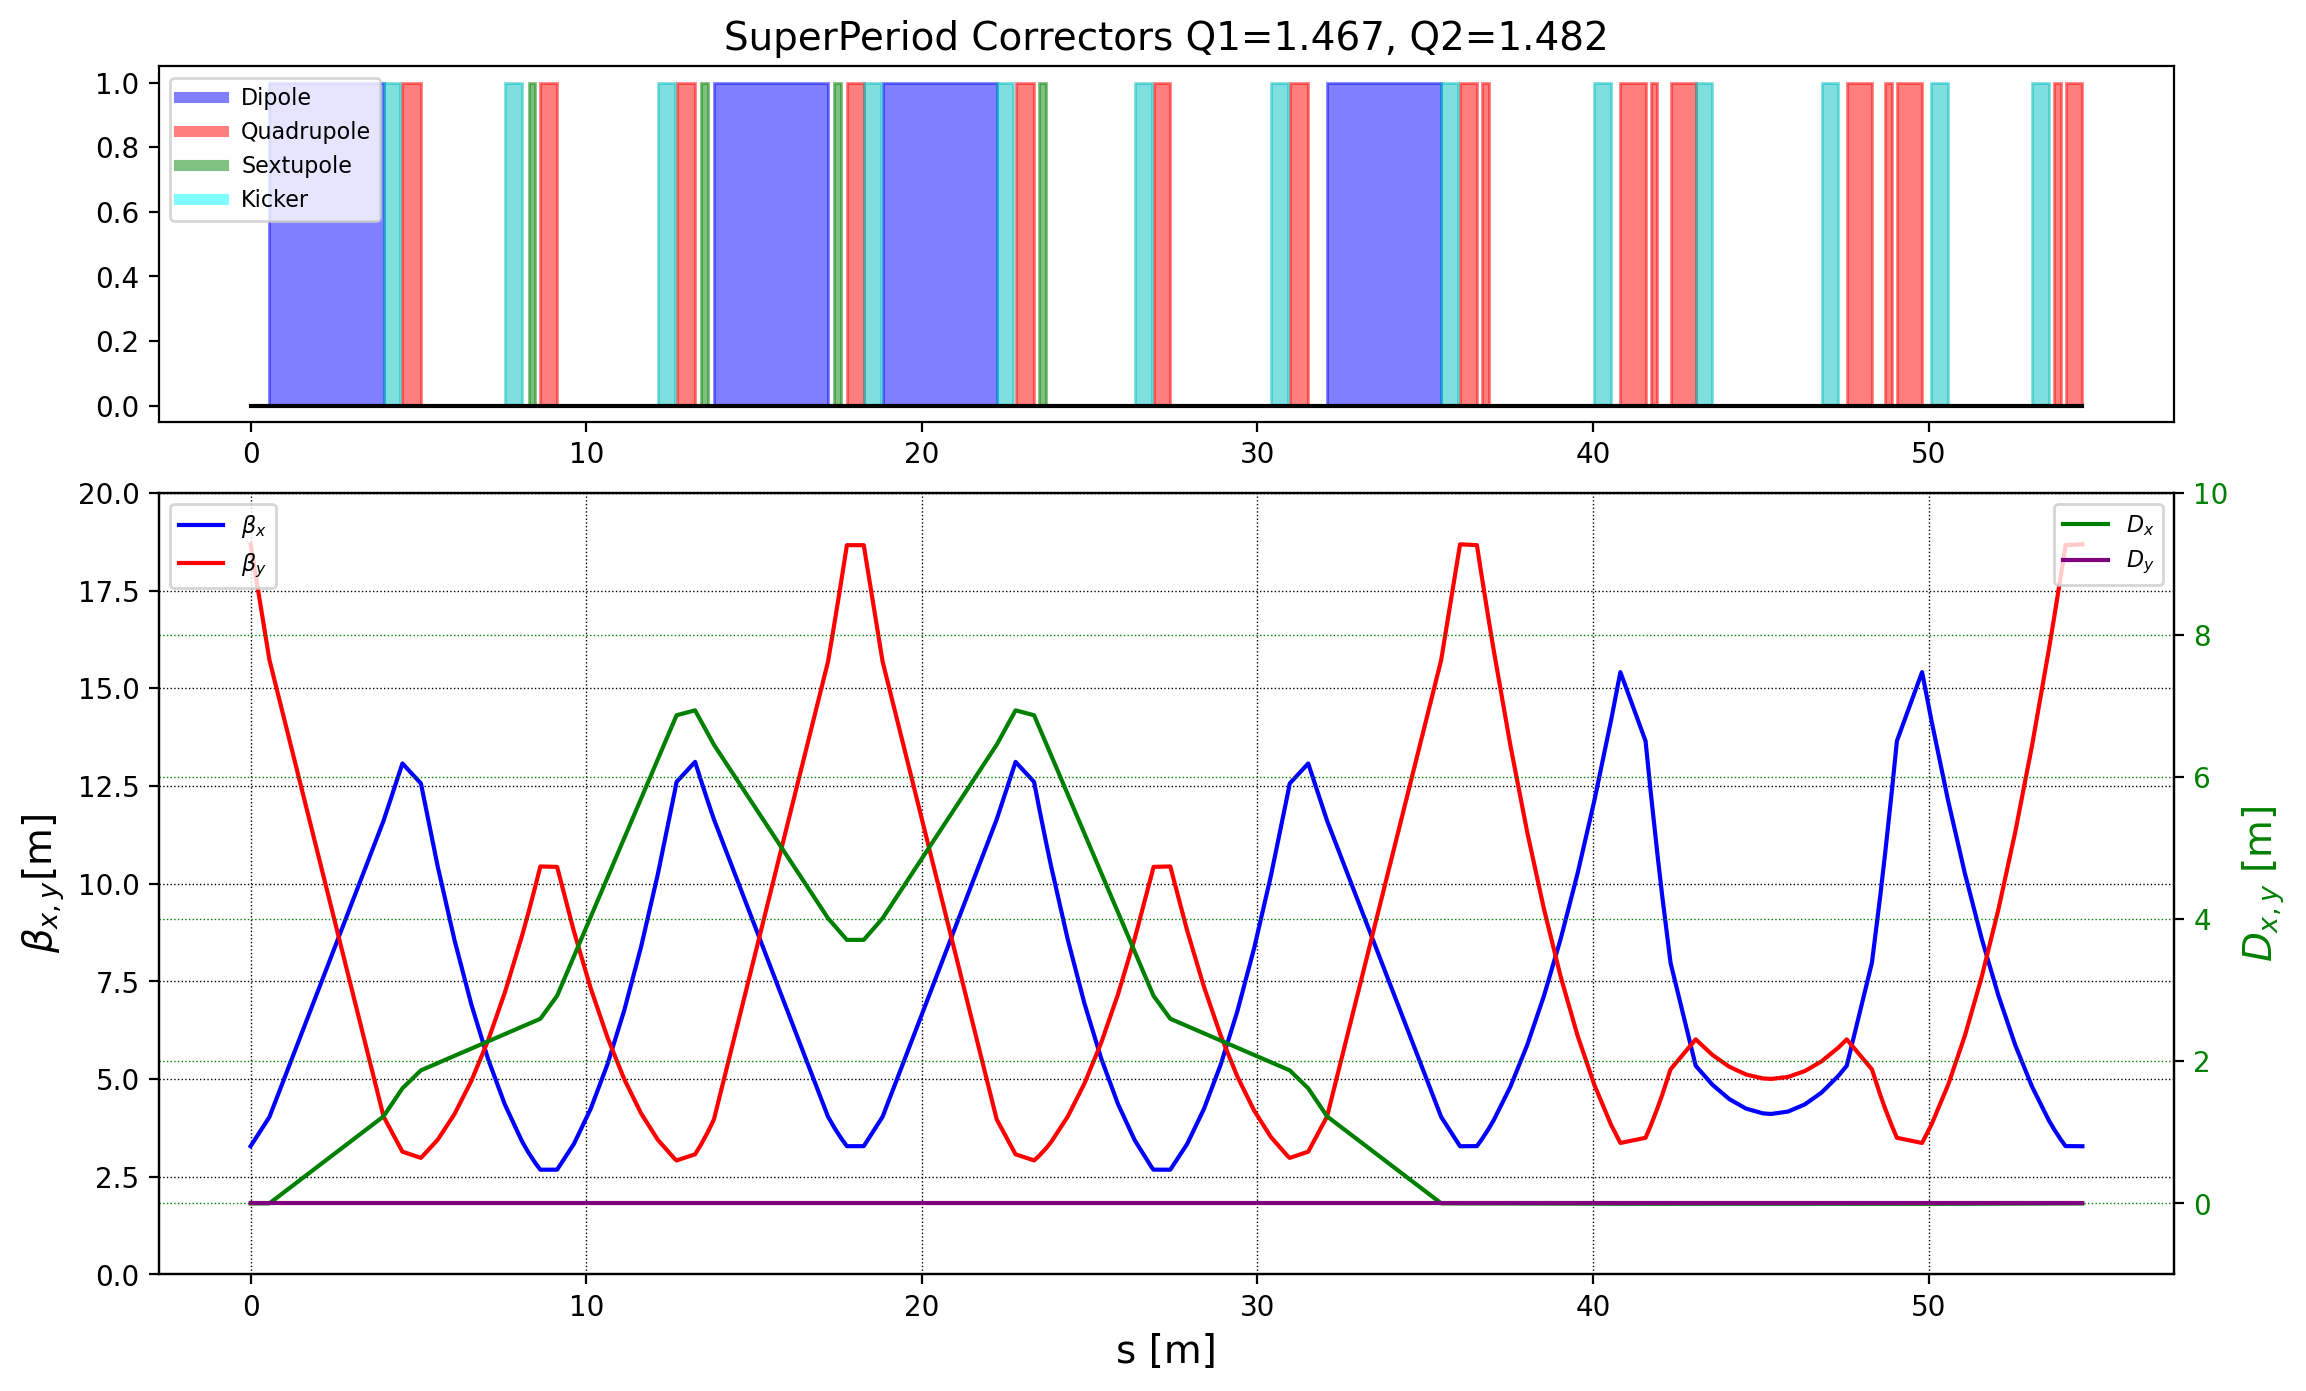

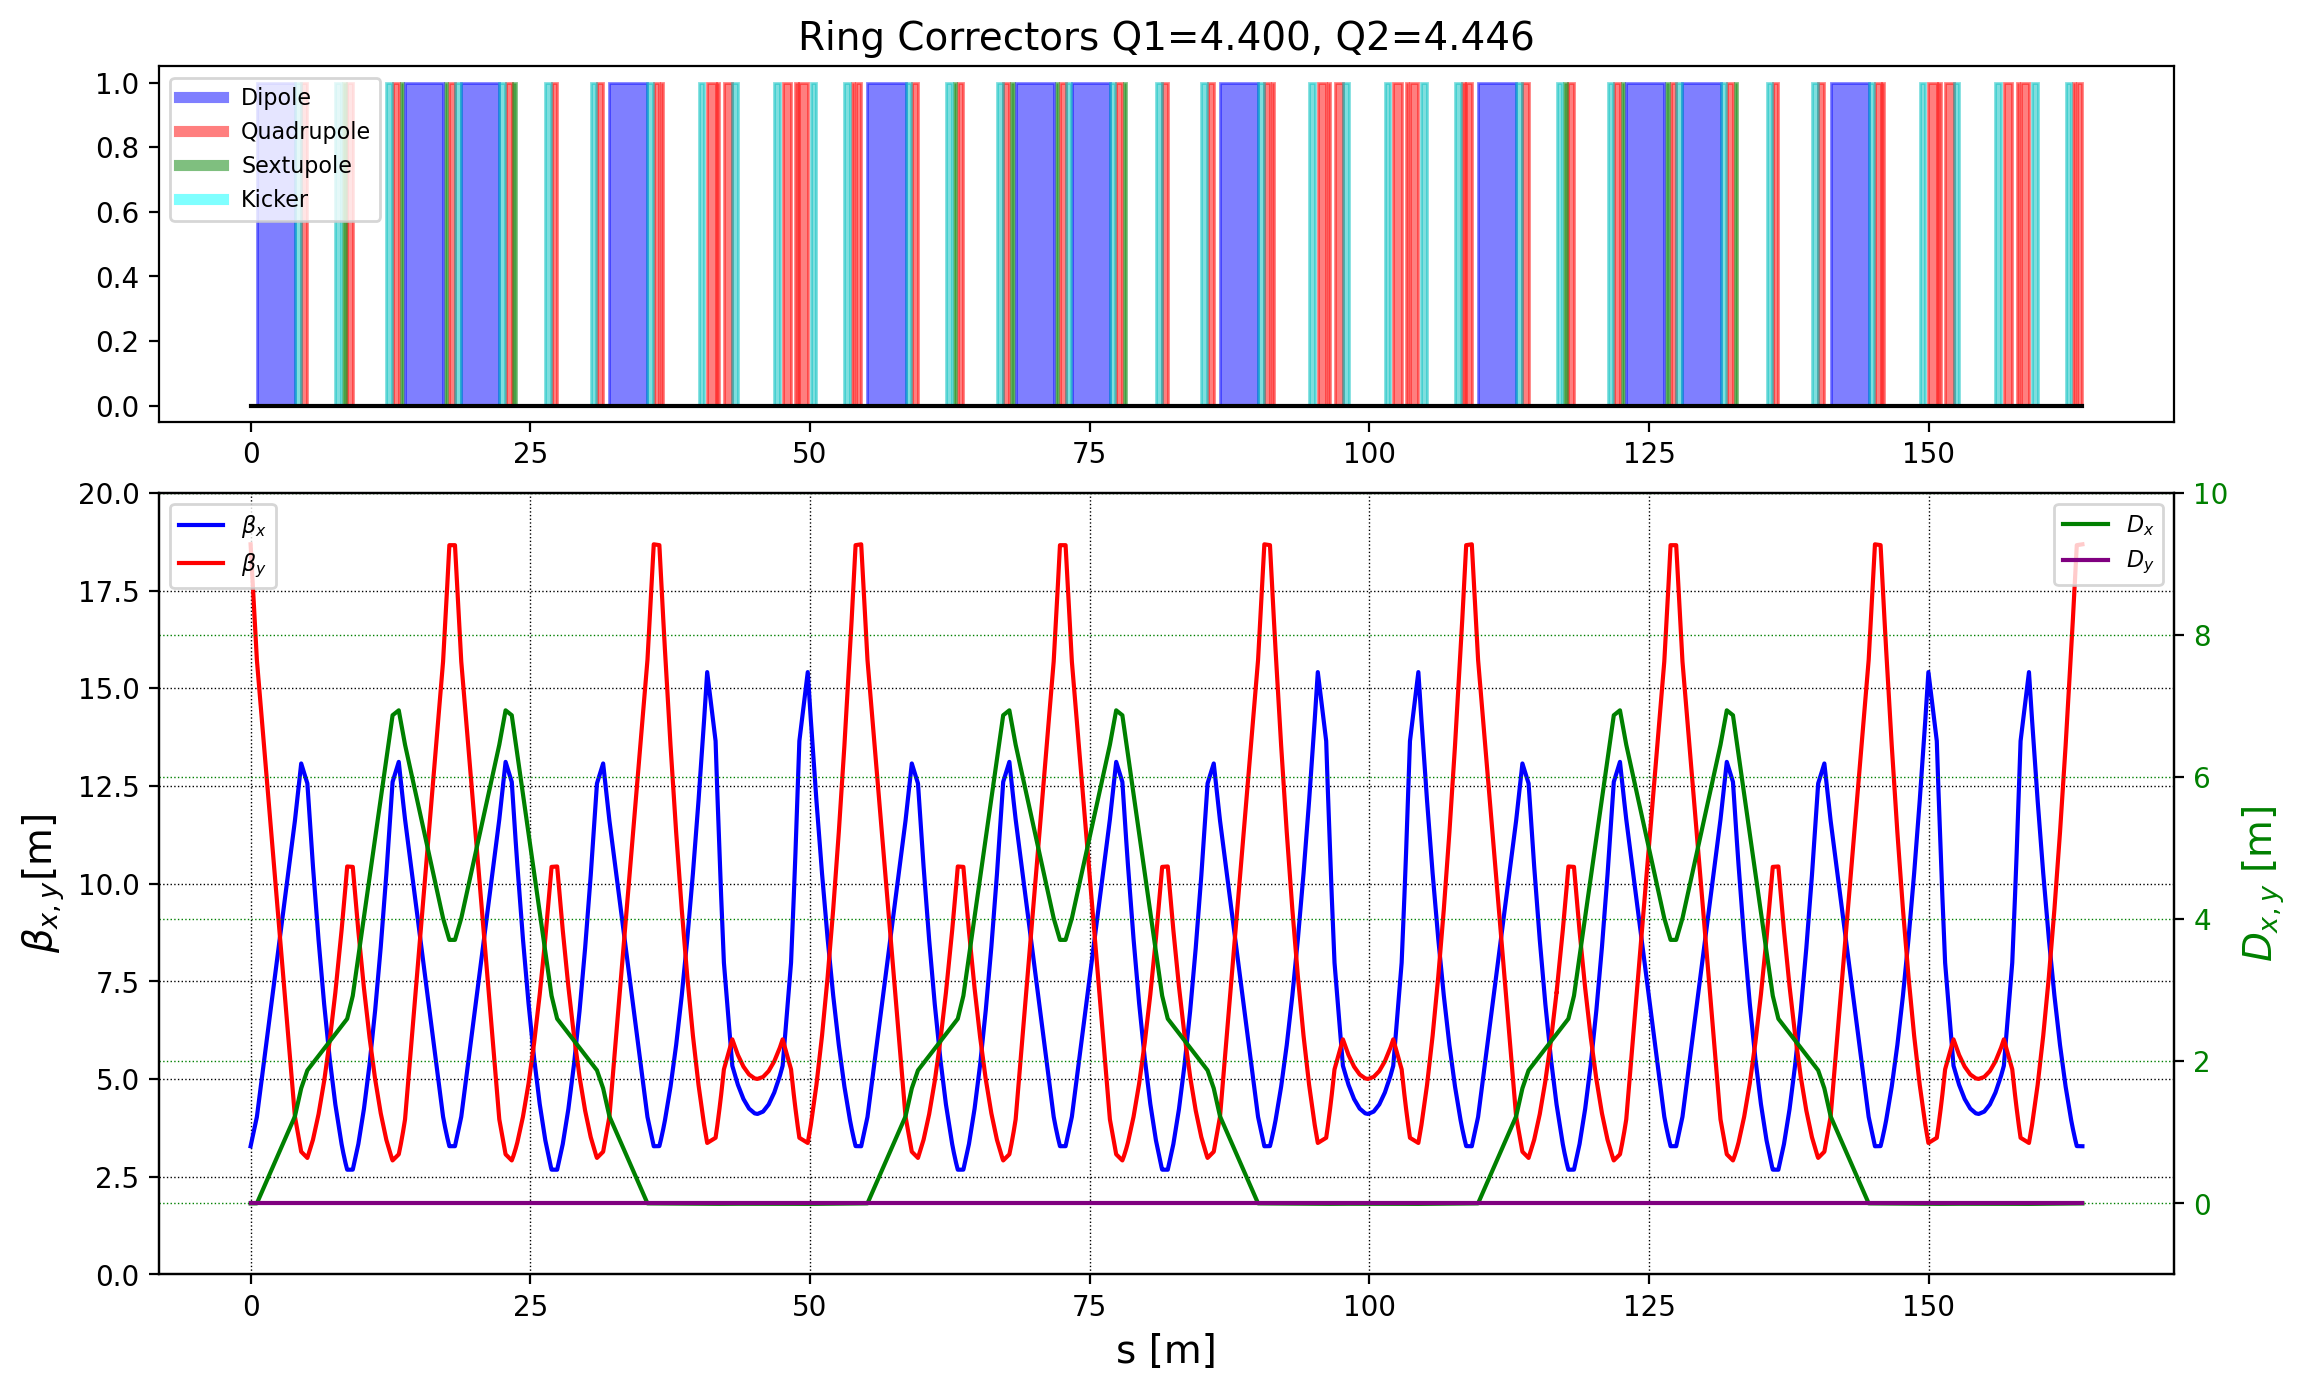

In [66]:
cpymad_logfile3 = './cpymad_logfile3.log'
madx3 = cpymad_start(cpymad_logfile3)

master_lattice_dir = 'Example_Lattice/'

madx3.call(file=master_lattice_dir+'Example_Synchrotron.beam')
madx3.call(file=master_lattice_dir+'Example_Synchrotron.strength')
madx3.call(file=master_lattice_dir+'Example_Synchrotron.elements')
madx3.call(file=master_lattice_dir+'Example_Synchrotron.sequence')  

sp_twiss_file = 'sp_corr_madx_twiss.tfs'
madx_twiss_ring = cpymad_madx_twiss(madx3, cpymad_logfile3, 'sp_corr', file_out=str(save_folder+sp_twiss_file))
cpymad_plot_madx_twiss_block(madx3, madx_twiss_ring, 'SuperPeriod Correctors', str(save_folder+'madx_twiss_sp_corr.png'))

ring_twiss_file = 'ring_corr_ind.tfs'
madx_twiss_ring = cpymad_madx_twiss(madx3, cpymad_logfile3, 'ring_corr_ind', file_out=str(save_folder+ring_twiss_file))
cpymad_plot_madx_twiss_block(madx3, madx_twiss_ring, 'Ring Correctors', str(save_folder+'madx_ring_corr_twiss.png'))

beta_limits = [5.3395, 6.0154]
beta_limits = [5.34, 6.02]
tunes = [4.4, 4.32]

#match_tune(madx3, 'ring_corr_ind', tunes[0], tunes[1], beta_limits)

In [67]:
cpymad_cod_correction_simulation_monitors_rms(madx3, cpymad_logfile3, 'ring_corr_ind', 10)

Sequence ring_corr_ind exists in this instance of MAD-X
Active sequence:

{'sp_corr': <Sequence: sp_corr>, 'ring_corr_ind': <Sequence: ring_corr_ind>}
